In [1]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Datasets/2transfers_rund_10-90.csv', low_memory = False)

In [2]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [25, 24]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [3]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [4]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [5]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [6]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [7]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [8]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [9]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [10]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [11]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [12]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [13]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [14]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 5,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = 0.001,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = 10,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = 0.035,  #initial learning rate 
        min_alpha = 0.001,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 150, total_examples = model.corpus_count, compute_loss = True, callbacks = [])
    
    return model

In [15]:
curr_model = training(sentences_series_np_train)

Validation loss decreased (inf --> 119670.929688).  Saving model ...
Validation loss decreased (119670.929688 --> 87347.132812).  Saving model ...
Validation loss decreased (87347.132812 --> 36295.781250).  Saving model ...
Validation loss decreased (36295.781250 --> 33482.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (33482.187500 --> 28428.468750).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (28428.468750 --> 25099.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (25099.687500 --> 23623.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (23623.125000 --> 23582.375000).  Saving model ...
EarlyS

In [16]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1, fraud_probv
    
    return 0, nfraud_probv

In [17]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []
    predictions_prob = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction, curr_prob = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)
        predictions_prob.append(curr_prob)

    return predictions, predictions_prob

In [18]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [19]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [20]:
#call predictions
prevs, prevs_prob = predict(curr_model, sentences_series_np_test, verbose1 = True, verbose2 = True)

['nbp', 'trfsep', 'c6627616', 'e3', 'r3', 'ntrusted', 'io983704', 'id45292', 'pbinka', 'nfraud', 'negaccount', 'ip85246198104', 'chrome', 'windows', 'dusk', 'w18', 'thu', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 3, 16413, 16414, 30, 2, 16, 16415, 6, 5, 17, 65, 21, 28, 4]
Fraud prob: 0.0010450292538735084
Non Fraud prob: 0.0010407684058009181
['nbp', 'trfsep', 'c3279256', 'e3', 'r3', 'trusted', 'io2666884', 'id5292796', 'kapbin', 'nfraud', 'arbed', 'ip18825120236', 'chrome', 'windows', 'dusk', 'w4', 'fri', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 9, 16417, 16418, 34, 2, 53, 16419, 6, 5, 17, 88, 22, 32, 4]
Fraud prob: 0.0009747729272930883
Non Fraud prob: 0.0009769034695636947
['mbp', 'trfsep', 'c2029094', 'e3', 'r3', 'ntrusted', 'io2029096', 'id14698492', 'inkapb', 'nfraud', 'negaccount', 'ip775423479', 'other', 'android', 'afternoon', 'w13', 'wed', 'mar', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 16421, 16422, 37, 2, 16, 16423, 18, 15, 14, 104, 25, 50, 19]
Fraud prob: 0.001038406603584007

Transaction: [13, 8, 0, 1, 9, 16506, 16507, 33, 2, 16, 16508, 24, 27, 14, 97, 57, 50, 23]
Fraud prob: 0.0016740545434004162
Non Fraud prob: 0.0016746596265875269
['mbp', 'trfmbw', 'c2179867', 'e3', 'r3', 'ntrusted', 'io2179869', 'id18886746', 'apink', 'nfraud', 'negaccount', 'ip17678112229', 'safari', 'ios', 'dusk', 'w22', 'sun', 'may', 'tmobile']
Transaction: [13, 114, 0, 1, 3, 16510, 16511, 117, 2, 16, 16512, 24, 27, 17, 79, 57, 29, 23]
Fraud prob: 0.0012236842776474077
Non Fraud prob: 0.00122474348245305
['nbe', 'trfint', 'c2128981', 'e3', 'r3', 'ntrusted', 'io2128982', 'id14850398', 'kapbin', 'nfraud', 'cdarbe', 'ip82154216138', 'chrome', 'windows', 'dusk', 'w19', 'mon', 'may', 'pc']
Transaction: [10, 8, 0, 1, 3, 16514, 16515, 34, 2, 38, 16516, 6, 5, 17, 67, 20, 29, 4]
Fraud prob: 0.0015223734189930838
Non Fraud prob: 0.0015246973671310116
['mbp', 'trfsep', 'c2262172', 'e3', 'r3', 'ntrusted', 'io511285', 'id11756508', 'kapbin', 'nfraud', 'negaccount', 'ip946037252', 'other', 'andro

Transaction: [10, 7, 0, 1, 3, 16600, 16601, 34, 2, 46, 16602, 61, 5, 12, 89, 25, 28, 4]
Fraud prob: 0.0012102991504434613
Non Fraud prob: 0.0012134502803746727
['mbp', 'trfint', 'c1912411', 'e3', 'r3', 'ntrusted', 'io2761061', 'id1912412', 'kapin', 'nfraud', 'negaccount', 'ip871035875', 'other', 'android', 'afternoon', 'w14', 'thu', 'apr', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 16604, 16605, 75, 2, 16, 16606, 18, 15, 14, 74, 21, 28, 19]
Fraud prob: 0.001387215674185427
Non Fraud prob: 0.0013825975656800438
['nbe', 'trfsep', 'c1166405', 'e3', 'r3', 'trusted', 'io1166406', 'id1336268', 'bicnkap', 'nfraud', 'arbecdd', 'ip852433617', 'ie', 'windows', 'morning', 'w34', 'thu', 'aug', 'pc']
Transaction: [10, 7, 0, 1, 9, 16608, 16609, 105, 2, 82, 16610, 70, 5, 12, 121, 21, 63, 4]
Fraud prob: 0.001887569269456435
Non Fraud prob: 0.0018911052684416063
['mbp', 'trfsep', 'c6578214', 'e3', 'r3', 'ntrusted', 'io1839595', 'id6942299', 'nkapi', 'nfraud', 'negaccount', 'ip14990166133', 'other', 'andr

Transaction: [13, 8, 0, 1, 3, 16690, 16691, 34, 2, 60, 16692, 18, 15, 68, 102, 54, 43, 19]
Fraud prob: 0.0016740763239795342
Non Fraud prob: 0.0016740220271458384
['nbe', 'trfsep', 'c898537', 'e3', 'r3', 'trusted', 'io898539', 'id1009390', 'nkapbic', 'nfraud', 'ecdarb', 'ip8524222124', 'edge', 'windows', 'dusk', 'w45', 'thu', 'nov', 'pc']
Transaction: [10, 7, 0, 1, 9, 16694, 16695, 56, 2, 46, 16696, 61, 5, 17, 86, 21, 42, 4]
Fraud prob: 0.0019588552095228806
Non Fraud prob: 0.0019606969799497165
['nbe', 'trfsep', 'c1121379', 'e3', 'r3', 'ntrusted', 'io1121380', 'id1209562', 'pbinka', 'nfraud', 'darbe', 'ip8524214098', 'chrome', 'windows', 'night', 'w42', 'wed', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 3, 16698, 16699, 30, 2, 47, 16700, 6, 5, 39, 101, 25, 35, 4]
Fraud prob: 0.001139999945735326
Non Fraud prob: 0.001138077936047921
['nbe', 'trfsep', 'c1332259', 'e3', 'r3', 'trusted', 'io1332260', 'id866930', 'apbink', 'nfraud', 'darbe', 'ip85244148245', 'chrome', 'windows', 'morning', 'w9

Transaction: [10, 8, 0, 1, 9, 16777, 16778, 62, 2, 46, 16779, 6, 5, 14, 111, 22, 50, 4]
Fraud prob: 0.0018006068930844776
Non Fraud prob: 0.0018040291470242664
['nbp', 'trfint', 'c4343733', 'e3', 'r3', 'trusted', 'io345725', 'id9012285', 'binkap', 'nfraud', 'arbed', 'ip8915532127', 'chrome', 'windows', 'morning', 'w11', 'thu', 'mar', 'pc']
Transaction: [11, 8, 0, 1, 9, 16781, 16782, 33, 2, 53, 16783, 6, 5, 12, 115, 21, 50, 4]
Fraud prob: 0.0018120155655196868
Non Fraud prob: 0.0018078209104714915
['mbp', 'trfint', 'c7411462', 'e3', 'r3', 'ntrusted', 'io1784227', 'id1784226', 'binkap', 'nfraud', 'negaccount', 'ip871961340', 'other', 'android', 'night', 'w45', 'fri', 'nov', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 16785, 16786, 33, 2, 16, 16787, 18, 15, 39, 86, 22, 42, 19]
Fraud prob: 0.0013662329301951104
Non Fraud prob: 0.0013665665328517207
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'apbink', 'fraud', 'darbec', 'ip781308191', 'edge', 'windows', 'mor

Transaction: [10, 7, 0, 1, 3, 16863, 16864, 56, 2, 49, 16865, 6, 5, 12, 96, 26, 40, 4]
Fraud prob: 0.0011904990842594998
Non Fraud prob: 0.0011882613089255756
['mbp', 'trfsep', 'c3770900', 'e3', 'r3', 'ntrusted', 'io3770902', 'id1434066', 'nkapi', 'nfraud', 'negaccount', 'ip8710321171', 'other', 'android', 'afternoon', 'w17', 'wed', 'apr', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 16867, 16868, 58, 2, 16, 16869, 18, 15, 14, 69, 25, 28, 19]
Fraud prob: 0.0015254048230417538
Non Fraud prob: 0.0015298216203518678
['nbp', 'trfsep', 'c4612894', 'e3', 'r3', 'trusted', 'io86344', 'id4459771', 'binkap', 'nfraud', 'cdarbe', 'ip959410352', 'chrome', 'windows', 'morning', 'w52', 'mon', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 9, 16871, 16872, 33, 2, 38, 16873, 6, 5, 12, 95, 20, 36, 4]
Fraud prob: 0.0010366165297455154
Non Fraud prob: 0.0010407904119347222
['mbp', 'trfmbw', 'c9398434', 'e3', 'r3', 'ntrusted', 'io282541', 'id17781070', 'inkap', 'nfraud', 'negaccount', 'ip8710317110', 'other', 'androi

Transaction: [10, 7, 0, 1, 3, 6288, 16947, 33, 2, 41, 6286, 6, 5, 17, 77, 25, 35, 4]
Fraud prob: 0.0028717330261756047
Non Fraud prob: 0.002870532691666483
['nbp', 'trfint', 'c3729549', 'e3', 'r3', 'tunknown', 'io1034455', 'id1034456', 'binkap', 'nfraud', 'rbeda', 'ip109517184', 'safari', 'ios', 'afternoon', 'w22', 'wed', 'may', 'tmobile']
Transaction: [11, 8, 0, 1, 127, 16949, 16950, 33, 2, 60, 16951, 24, 27, 14, 79, 25, 29, 23]
Fraud prob: 0.0024836233496898785
Non Fraud prob: 0.0024852836249920074
['nbe', 'trfsep', 'c197015', 'e3', 'r3', 'trusted', 'io984928', 'id5451707', 'nkapbic', 'nfraud', 'becdar', 'ip188807818', 'edge', 'windows', 'morning', 'w41', 'mon', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 9, 16953, 16954, 56, 2, 49, 16955, 61, 5, 12, 84, 20, 35, 4]
Fraud prob: 0.0009004366929730168
Non Fraud prob: 0.0008997304557851749
['mbp', 'trfint', 'c1850550', 'e3', 'r3', 'ntrusted', 'io1850552', 'id15645282', 'pbinka', 'nfraud', 'negaccount', 'ip18825110612', 'other', 'android', 'a

Transaction: [11, 7, 0, 1, 3, 17035, 17036, 30, 2, 41, 17037, 6, 5, 12, 88, 57, 32, 4]
Fraud prob: 0.002808512348565273
Non Fraud prob: 0.002811998700053664
['nbe', 'trfsep', 'c5407605', 'e3', 'r3', 'ntrusted', 'io233674', 'id5617242', 'nkapbi', 'nfraud', 'cdarbe', 'ip2132220896', 'chrome', 'windows', 'morning', 'w15', 'wed', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 3, 17039, 17040, 48, 2, 38, 17041, 6, 5, 12, 92, 25, 28, 4]
Fraud prob: 0.0018591554489830742
Non Fraud prob: 0.0018578902945591835
['nbe', 'trfint', 'c1115448', 'e3', 'r3', 'trusted', 'io1115449', 'id2228842', 'kapbin', 'nfraud', 'cdarbe', 'ip1946568173', 'chrome', 'windows', 'morning', 'w9', 'fri', 'feb', 'pc']
Transaction: [10, 8, 0, 1, 9, 17043, 17044, 34, 2, 38, 17045, 6, 5, 12, 97, 22, 40, 4]
Fraud prob: 0.0009627131312299753
Non Fraud prob: 0.0009596931504347594
['nbp', 'trfint', 'c3229467', 'e3', 'r3', 'ntrusted', 'io1751016', 'id4051545', 'nkapbic', 'nfraud', 'cdarbe', 'ip85246528', 'chrome', 'windows', 'dusk', 'w2'

Transaction: [10, 7, 0, 1, 3, 17126, 17127, 31, 2, 38, 17128, 6, 5, 64, 76, 20, 32, 4]
Fraud prob: 0.0014244366066122893
Non Fraud prob: 0.001428766092431033
['mbp', 'trfint', 'c1889889', 'e3', 'r3', 'ntrusted', 'io1889891', 'id1889890', 'kapbin', 'nfraud', 'bedar', 'ip87196233146', 'other', 'android', 'morning', 'w40', 'fri', 'oct', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 17130, 17131, 34, 2, 83, 17132, 18, 15, 12, 85, 22, 35, 19]
Fraud prob: 0.0012347104147920618
Non Fraud prob: 0.0012332952192082303
['nbe', 'trfsep', 'c1257676', 'e3', 'r3', 'trusted', 'io1257677', 'id1321528', 'cnkapbi', 'nfraud', 'cdarbe', 'ip871967311', 'chrome', 'android', 'dusk', 'w43', 'sat', 'oct', 'tmobile']
Transaction: [10, 7, 0, 1, 9, 17134, 17135, 62, 2, 38, 160, 6, 15, 17, 103, 54, 35, 23]
Fraud prob: 0.001129553425926133
Non Fraud prob: 0.0011292625040368875
['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'apbink', 'fraud', 'arbecd', 'ip622821682', 'chrome', 'windows', '

Transaction: [11, 7, 0, 1, 3, 17208, 134, 48, 45, 38, 136, 6, 5, 39, 69, 25, 28, 4]
Fraud prob: 0.0018098564687534235
Non Fraud prob: 0.0018093061553372536
['nbe', 'trfint', 'c1013932', 'e3', 'r3', 'trusted', 'io1013933', 'id1013934', 'binkap', 'nfraud', 'arbed', 'ip19724926227', 'chrome', 'windows', 'night', 'w21', 'mon', 'may', 'pc']
Transaction: [10, 8, 0, 1, 9, 17210, 17211, 33, 2, 53, 17212, 6, 5, 39, 78, 20, 29, 4]
Fraud prob: 0.0019190072653145762
Non Fraud prob: 0.001914370188387693
['mbp', 'trfint', 'c2222565', 'e3', 'r3', 'ntrusted', 'io2222567', 'id2717149', 'apbink', 'nfraud', 'arbed', 'ip89153217122', 'safari', 'ios', 'earlymorning', 'w48', 'mon', 'nov', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 17214, 17215, 31, 2, 53, 17216, 24, 27, 64, 81, 20, 42, 23]
Fraud prob: 0.0014110878000792582
Non Fraud prob: 0.0014090422446315642
['nbe', 'trfsep', 'c1170266', 'e3', 'r3', 'ntrusted', 'io1170268', 'id1507689', 'inkapb', 'nfraud', 'becdar', 'ip8710392206', 'chrome', 'windows', 'mor

Transaction: [13, 114, 0, 1, 3, 17291, 17292, 30, 2, 16, 17293, 24, 27, 14, 73, 25, 29, 23]
Fraud prob: 0.002165653851989191
Non Fraud prob: 0.0021660437269019894
['nbe', 'trfint', 'c1209890', 'e3', 'r3', 'trusted', 'io442027', 'id791364', 'nkapbi', 'nfraud', 'arbecd', 'ip622813171', 'chrome', 'windows', 'afternoon', 'w46', 'thu', 'nov', 'pc']
Transaction: [10, 8, 0, 1, 9, 17295, 17296, 48, 2, 66, 17297, 6, 5, 14, 109, 21, 42, 4]
Fraud prob: 0.0017525545554235578
Non Fraud prob: 0.0017499939349363558
['nbe', 'trfsep', 'c7740883', 'e3', 'r3', 'trusted', 'io1143549', 'id1764192', 'inkapb', 'nfraud', 'arbecd', 'ip144649191', 'chrome', 'windows', 'morning', 'w48', 'thu', 'nov', 'pc']
Transaction: [10, 7, 0, 1, 9, 17299, 17300, 37, 2, 66, 17301, 6, 5, 12, 81, 21, 42, 4]
Fraud prob: 0.0011387150625523645
Non Fraud prob: 0.0011407468264224008
['nbp', 'trfsep', 'c117033', 'e3', 'r3', 'ntrusted', 'io117035', 'id725161', 'binkap', 'nfraud', 'cdarbe', 'ip8918117058', 'chrome', 'windows', 'night',

Transaction: [13, 8, 0, 1, 3, 17380, 17381, 33, 2, 16, 17382, 18, 15, 17, 92, 25, 28, 19]
Fraud prob: 0.0012833692780986894
Non Fraud prob: 0.0012859156704507768
['mbp', 'trfint', 'c2190926', 'e3', 'r3', 'ntrusted', 'io2190927', 'id2190928', 'nkapi', 'nfraud', 'bedar', 'ip1499022833', 'safari', 'ios', 'afternoon', 'w43', 'wed', 'oct', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 17384, 17385, 58, 2, 83, 17386, 24, 27, 14, 103, 25, 35, 23]
Fraud prob: 0.001061654562363401
Non Fraud prob: 0.0010624528695188928
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'pink', 'fraud', 'cdarbe', 'ip9595160191', 'edge', 'windows', 'morning', 'w5', 'sat', 'feb', 'pc']
Transaction: [11, 8, 0, 1, 9, 176, 177, 125, 45, 38, 518, 61, 5, 12, 72, 54, 40, 4]
Fraud prob: 0.0022584491829940154
Non Fraud prob: 0.002258443965465828
['mbp', 'trfint', 'c9078500', 'e3', 'r3', 'ntrusted', 'io8610255', 'id14223261', 'kapbin', 'nfraud', 'negaccount', 'ip852421075', 'other', 'android', 'dusk',

Transaction: [11, 7, 0, 1, 9, 17462, 17463, 37, 2, 53, 17464, 6, 5, 12, 103, 22, 35, 4]
Fraud prob: 0.0013417815171123948
Non Fraud prob: 0.001346335619018646
['mbp', 'trfint', 'c4283783', 'e3', 'r3', 'ntrusted', 'io4497651', 'id4283785', 'pbinka', 'nfraud', 'negaccount', 'ip8710362109', 'other', 'android', 'morning', 'w7', 'tue', 'feb', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 17466, 17467, 30, 2, 16, 17468, 18, 15, 12, 90, 26, 40, 19]
Fraud prob: 0.000972473853835254
Non Fraud prob: 0.0009740632649481995
['mbp', 'trfsep', 'c5118241', 'e3', 'r3', 'trusted', 'io328936', 'id25163', 'pbinka', 'nfraud', 'negaccount', 'ip8322322746', 'other', 'android', 'earlymorning', 'w2', 'mon', 'jan', 'ttablet']
Transaction: [13, 7, 0, 1, 9, 17470, 8068, 30, 2, 16, 17471, 18, 15, 64, 76, 20, 32, 19]
Fraud prob: 0.001541372806968866
Non Fraud prob: 0.0015414142690133303
['nbp', 'trfsep', 'c3140395', 'e3', 'r3', 'ntrusted', 'io613993', 'id2581679', 'binkap', 'nfraud', 'rbeda', 'ip8513816520', 'chrome', '

Transaction: [11, 8, 0, 1, 3, 17548, 17549, 117, 2, 49, 130, 6, 5, 12, 103, 25, 35, 4]
Fraud prob: 0.001588895062013762
Non Fraud prob: 0.001591226475284202
['nbe', 'trfint', 'c1153955', 'e3', 'r3', 'trusted', 'io7779128', 'id21869', 'nkapbic', 'nfraud', 'darbecd', 'ip9513673176', 'safari', 'macosx', 'dusk', 'w49', 'mon', 'dec', 'pc']
Transaction: [10, 8, 0, 1, 9, 17551, 17552, 56, 2, 116, 17553, 24, 59, 17, 91, 20, 36, 4]
Fraud prob: 0.0012700592069450067
Non Fraud prob: 0.0012714832246274455
['nbp', 'trfips', 'c9484502', 'e3', 'r3', 'trusted', 'io1483102', 'id10302018', 'nkapbi', 'fraud', 'arbed', 'ip525481170', 'chrome', 'windows', 'afternoon', 'w52', 'thu', 'dec', 'pc']
Transaction: [11, 44, 0, 1, 9, 17554, 1349, 48, 45, 53, 485, 6, 5, 14, 95, 21, 36, 4]
Fraud prob: 0.001963765406666873
Non Fraud prob: 0.0019629953761564067
['mbp', 'trfsep', 'c1736434', 'e3', 'r3', 'ntrusted', 'io743352', 'id4335024', 'kapbin', 'nfraud', 'rbeda', 'ip1499024025', 'other', 'android', 'dawn', 'w43', '

Transaction: [13, 8, 0, 1, 9, 17626, 17627, 34, 2, 16, 17628, 24, 27, 12, 97, 54, 40, 19]
Fraud prob: 0.0007436817490997782
Non Fraud prob: 0.0007422171643156616
['nbp', 'trfint', 'c11867603', 'e3', 'r3', 'ntrusted', 'io9098285', 'id12641545', 'inkapb', 'nfraud', 'darbe', 'ip946219417', 'edge', 'windows', 'dusk', 'w10', 'tue', 'mar', 'pc']
Transaction: [11, 8, 0, 1, 3, 17630, 17631, 37, 2, 47, 17632, 61, 5, 17, 118, 26, 50, 4]
Fraud prob: 0.0015874166601861361
Non Fraud prob: 0.0015883527412370313
['nbp', 'trfint', 'c3343981', 'e3', 'r3', 'trusted', 'io704145', 'id4164820', 'nkapbi', 'nfraud', 'darbec', 'ip81193102253', 'other', 'windows', 'dusk', 'w47', 'thu', 'nov', 'otherd']
Transaction: [11, 8, 0, 1, 9, 17634, 17635, 48, 2, 41, 17636, 18, 5, 17, 100, 21, 42, 120]
Fraud prob: 0.0019982934936706442
Non Fraud prob: 0.0019989679458376486
['mbp', 'trfint', 'c2357028', 'e3', 'r3', 'ntrusted', 'io2357029', 'id2357030', 'kapin', 'nfraud', 'negaccount', 'ip1486955254', 'safari', 'ios', 'daw

Transaction: [13, 7, 0, 1, 3, 17714, 17715, 37, 2, 16, 17716, 18, 15, 17, 72, 22, 32, 19]
Fraud prob: 0.0014772001741221175
Non Fraud prob: 0.0014818443632975686
['nbp', 'trfsep', 'c5257865', 'e3', 'r3', 'ntrusted', 'io85213', 'id170284', 'inkap', 'nfraud', 'arbed', 'ip95932894', 'chrome', 'windows', 'afternoon', 'w22', 'fri', 'may', 'pc']
Transaction: [11, 7, 0, 1, 3, 17718, 17719, 52, 2, 53, 17720, 6, 5, 14, 79, 22, 29, 4]
Fraud prob: 0.0017042209328792524
Non Fraud prob: 0.001706662485958077
['mbp', 'trfsep', 'c2054085', 'e3', 'r3', 'ntrusted', 'io2054086', 'id4348803', 'inkapb', 'nfraud', 'darbe', 'ip28087185', 'other', 'android', 'dawn', 'w47', 'wed', 'nov', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 17722, 17723, 37, 2, 47, 17724, 18, 15, 68, 100, 25, 42, 19]
Fraud prob: 0.0015364843347924761
Non Fraud prob: 0.0015333629453380127
['nbe', 'trfsep', 'c800032', 'e3', 'r3', 'ntrusted', 'io800033', 'id5725149', 'apbink', 'nfraud', 'darbe', 'ip6248201137', 'safari', 'macosx', 'afternoon'

Transaction: [13, 7, 0, 1, 9, 17797, 17798, 37, 2, 47, 17799, 18, 15, 17, 109, 20, 42, 19]
Fraud prob: 0.001445322684958228
Non Fraud prob: 0.001445297939426382
['nbe', 'trfsep', 'c842282', 'e3', 'r3', 'ntrusted', 'io842283', 'id1337447', 'icnkapb', 'nfraud', 'cdarbe', 'ip88157174234', 'chrome', 'windows', 'morning', 'w15', 'thu', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 3, 17801, 17802, 71, 2, 38, 17803, 6, 5, 12, 92, 21, 28, 4]
Fraud prob: 0.0009399280897923745
Non Fraud prob: 0.0009394503613293637
['nbp', 'trfint', 'c4312855', 'e3', 'r3', 'trusted', 'io256024', 'id426440', 'pbinka', 'fraud', 'darbe', 'ip52498350', 'chrome', 'android', 'night', 'w6', 'wed', 'feb', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 224, 201, 30, 45, 47, 216, 6, 15, 39, 80, 25, 40, 23]
Fraud prob: 0.0023050466843314472
Non Fraud prob: 0.002304925716604945
['nbe', 'trfsep', 'c1687417', 'e3', 'r3', 'ntrusted', 'io777791', 'id2422506', 'cnkapbi', 'nfraud', 'cddarbe', 'ip832401704', 'chrome', 'windows', 'morning', 'w

Transaction: [10, 7, 0, 1, 3, 17881, 17882, 37, 2, 47, 17883, 6, 5, 12, 73, 26, 29, 4]
Fraud prob: 0.0011926716961170314
Non Fraud prob: 0.0011914090227946872
['nbe', 'trfsep', 'c1021781', 'e3', 'r3', 'trusted', 'io1021858', 'id1355240', 'nkapbic', 'nfraud', 'rbecda', 'ip7754237179', 'chrome', 'windows', 'night', 'w2', 'thu', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 9, 17885, 17886, 56, 2, 55, 17887, 6, 5, 39, 76, 21, 32, 4]
Fraud prob: 0.0014466499014815781
Non Fraud prob: 0.0014463197439908981
['nbp', 'trfsep', 'c4001621', 'e3', 'r3', 'ntrusted', 'io4001623', 'id131757', 'kapbin', 'nfraud', 'darbe', 'ip51583240', 'chrome', 'windows', 'night', 'w2', 'thu', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 3, 17889, 17890, 34, 2, 47, 17891, 6, 5, 39, 76, 21, 32, 4]
Fraud prob: 0.0009977557192542008
Non Fraud prob: 0.0009923027091645054
['nbe', 'trfsep', 'c796808', 'e3', 'r3', 'ntrusted', 'io796811', 'id1700246', 'nkapbi', 'nfraud', 'rbecda', 'ip85240146239', 'chrome', 'windows', 'afternoon', 'w14

Transaction: [13, 8, 0, 1, 3, 17971, 17972, 52, 2, 126, 17973, 18, 15, 14, 93, 26, 43, 19]
Fraud prob: 0.0011680821880872827
Non Fraud prob: 0.0011719089343387168
['nbe', 'trfsep', 'c2714331', 'e3', 'r3', 'trusted', 'io890722', 'id4537196', 'icnkapb', 'nfraud', 'arbecd', 'ip18825015329', 'chrome', 'windows', 'afternoon', 'w5', 'wed', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 9, 17975, 17976, 71, 2, 66, 17977, 6, 5, 14, 72, 25, 32, 4]
Fraud prob: 0.0018209850150014972
Non Fraud prob: 0.0018213189778180094
['mbp', 'trfint', 'c4219082', 'e3', 'r3', 'ntrusted', 'io4219519', 'id276790', 'pinka', 'nfraud', 'rbeda', 'ip8719680235', 'other', 'android', 'dawn', 'w48', 'sun', 'dec', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 17979, 17980, 132, 2, 60, 17981, 18, 15, 68, 81, 57, 36, 19]
Fraud prob: 0.0009922136705426965
Non Fraud prob: 0.0009957506408682093
['nbe', 'trfsep', 'c1171887', 'e3', 'r3', 'trusted', 'io1171889', 'id2595178', 'kapbin', 'nfraud', 'darbe', 'ip9413225393', 'firefox', 'windows', 

Transaction: [11, 8, 0, 1, 9, 18053, 212, 30, 2, 83, 18054, 6, 5, 14, 93, 22, 43, 4]
Fraud prob: 0.0016305413155350834
Non Fraud prob: 0.0016300820279866457
['nbp', 'trfint', 'c3294827', 'e3', 'r3', 'trusted', 'io1600764', 'id3294828', 'pbinka', 'nfraud', 'darbe', 'ip81193188197', 'chrome', 'windows', 'afternoon', 'w10', 'mon', 'mar', 'pc']
Transaction: [11, 8, 0, 1, 9, 18056, 18057, 30, 2, 47, 18058, 6, 5, 14, 118, 20, 50, 4]
Fraud prob: 0.0009369007352688641
Non Fraud prob: 0.0009380097294524603
['mbp', 'trfint', 'c1954345', 'e3', 'r3', 'ntrusted', 'io1954346', 'id5717359', 'nkapbi', 'nfraud', 'negaccount', 'ip9310815134', 'safari', 'ios', 'dawn', 'w13', 'thu', 'mar', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 18060, 18061, 48, 2, 16, 18062, 24, 27, 68, 104, 21, 50, 23]
Fraud prob: 0.0010564869471636484
Non Fraud prob: 0.001056165022419009
['nbe', 'trfsep', 'c1997705', 'e3', 'r3', 'ntrusted', 'io1997707', 'id2450226', 'kapbin', 'nfraud', 'rbecda', 'ip8915218713', 'chrome', 'windows', '

Transaction: [13, 8, 0, 1, 3, 18147, 18148, 34, 2, 16, 18149, 18, 15, 14, 77, 25, 35, 19]
Fraud prob: 0.0009514694465906359
Non Fraud prob: 0.0009512711403658614
['nbe', 'trfsep', 'c818427', 'e3', 'r3', 'ntrusted', 'io818429', 'id847561', 'inkap', 'nfraud', 'ecdarb', 'ip77111247154', 'chrome', 'windows', 'dusk', 'w43', 'tue', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 3, 18151, 18152, 52, 2, 46, 18153, 6, 5, 17, 103, 26, 35, 4]
Fraud prob: 0.0015438986010849476
Non Fraud prob: 0.0015407673017762136
['nbp', 'trfint', 'c3133710', 'e3', 'r3', 'trusted', 'io5213950', 'id3133712', 'kapin', 'nfraud', 'cdarbe', 'ip14990181114', 'safari', 'macosx', 'dusk', 'w51', 'wed', 'dec', 'pc']
Transaction: [11, 8, 0, 1, 9, 18155, 18156, 75, 2, 38, 18157, 24, 59, 17, 94, 25, 36, 4]
Fraud prob: 0.0008581327620049706
Non Fraud prob: 0.0008544382599211531
['nbe', 'trfsep', 'c1154270', 'e3', 'r3', 'trusted', 'io1154272', 'id2461423', 'apbink', 'nfraud', 'ecdarb', 'ip1486324945', 'firefox', 'windows', 'afternoon'

Transaction: [11, 7, 0, 1, 3, 18238, 18239, 30, 2, 53, 18240, 6, 5, 17, 86, 26, 42, 4]
Fraud prob: 0.0012184691986476537
Non Fraud prob: 0.001222264691023156
['nbe', 'trfint', 'c1534632', 'e3', 'r3', 'trusted', 'io1446193', 'id442291', 'apbink', 'nfraud', 'arbecd', 'ip622849211', 'chrome', 'windows', 'afternoon', 'w22', 'fri', 'may', 'pc']
Transaction: [10, 8, 0, 1, 9, 18242, 18243, 31, 2, 66, 18244, 6, 5, 14, 79, 22, 29, 4]
Fraud prob: 0.0014207260264811339
Non Fraud prob: 0.0014212880760169355
['nbp', 'trfsep', 'c4696914', 'e3', 'r3', 'ntrusted', 'io649033', 'id15167026', 'pbinka', 'nfraud', 'negaccount', 'ip8524682136', 'chrome', 'windows', 'afternoon', 'w19', 'tue', 'may', 'pc']
Transaction: [11, 7, 0, 1, 3, 18246, 18247, 30, 2, 16, 18248, 6, 5, 14, 67, 26, 29, 4]
Fraud prob: 0.0006869513536003069
Non Fraud prob: 0.0006846921796750394
['mbp', 'trfsep', 'c14548929', 'e3', 'r3', 'ntrusted', 'io106431', 'id1952363', 'inkapb', 'nfraud', 'negaccount', 'ip1767816243', 'safari', 'ios', 'a

Transaction: [106, 8, 0, 1, 3, 18332, 18333, 62, 2, 46, 107, 18, 15, 12, 67, 21, 29, 19]
Fraud prob: 0.0010785800841404125
Non Fraud prob: 0.0010769499349407852
['mbp', 'trfmbw', 'c5549484', 'e3', 'r3', 'ntrusted', 'io5549486', 'id16189859', 'inkap', 'nfraud', 'negaccount', 'ip9461142209', 'other', 'android', 'afternoon', 'w21', 'sat', 'may', 'ttablet']
Transaction: [13, 114, 0, 1, 3, 18335, 18336, 52, 2, 16, 18337, 18, 15, 14, 78, 54, 29, 19]
Fraud prob: 0.001288580082473345
Non Fraud prob: 0.0012876045148004778
['mbp', 'trfsep', 'c3760961', 'e3', 'r3', 'ntrusted', 'io3760962', 'id250686', 'pink', 'nfraud', 'rbeda', 'ip85241238164', 'safari', 'ios', 'night', 'w43', 'wed', 'oct', 'tmobile']
Transaction: [13, 7, 0, 1, 3, 18339, 18340, 125, 2, 60, 18341, 24, 27, 39, 103, 25, 35, 23]
Fraud prob: 0.001616520563402446
Non Fraud prob: 0.0016165234374057036
['mbp', 'trfint', 'c2540337', 'e3', 'r3', 'ntrusted', 'io13895416', 'id2540339', 'inkap', 'nfraud', 'negaccount', 'ip8719680223', 'safari

Transaction: [10, 7, 0, 1, 3, 18422, 18423, 33, 2, 46, 18424, 6, 5, 14, 69, 26, 28, 4]
Fraud prob: 0.001053431689797435
Non Fraud prob: 0.0010525360994506627
['mbp', 'trfint', 'c1979521', 'e3', 'r3', 'ntrusted', 'io1261942', 'id1400498', 'pbinka', 'nfraud', 'rbeda', 'ip8524618913', 'other', 'android', 'dusk', 'w50', 'tue', 'dec', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 18426, 18427, 30, 2, 60, 18428, 18, 15, 17, 99, 26, 36, 19]
Fraud prob: 0.0011027949594790698
Non Fraud prob: 0.0011011872638846398
['nbe', 'trfint', 'c4197934', 'e3', 'r3', 'ntrusted', 'io4197936', 'id1105806', 'pbinka', 'nfraud', 'darbe', 'ip871031461', 'chrome', 'windows', 'morning', 'w39', 'fri', 'sep', 'pc']
Transaction: [10, 8, 0, 1, 3, 18430, 18431, 30, 2, 47, 18432, 6, 5, 12, 93, 22, 43, 4]
Fraud prob: 0.0014653488251497038
Non Fraud prob: 0.0014657236424682196
['nbp', 'trfsep', 'c3735503', 'e3', 'r3', 'trusted', 'io195030', 'id1021757', 'nkapbic', 'nfraud', 'rbecda', 'ip8259195104', 'safari', 'macosx', 'dawn', 

Transaction: [10, 7, 0, 1, 9, 18510, 18511, 34, 2, 47, 18512, 18513, 274, 12, 110, 20, 43, 4]
Fraud prob: 0.0011515077621879755
Non Fraud prob: 0.0011514036759763258
['nbp', 'trfsep', 'c3174456', 'e3', 'r3', 'trusted', 'io713428', 'id2950689', 'apbink', 'nfraud', 'rbeda', 'ip851391881', 'chrome', 'windows', 'dusk', 'w20', 'wed', 'may', 'pc']
Transaction: [11, 7, 0, 1, 9, 18515, 18516, 31, 2, 60, 18517, 6, 5, 17, 73, 25, 29, 4]
Fraud prob: 0.0015510924895352218
Non Fraud prob: 0.0015533238110947423
['nbe', 'trfsep', 'c857838', 'e3', 'r3', 'ntrusted', 'io857839', 'id10906820', 'apbink', 'nfraud', 'darbecd', 'ip89180255183', 'safari', 'macosx', 'night', 'w2', 'tue', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 3, 18519, 18520, 31, 2, 116, 18521, 24, 59, 39, 76, 26, 32, 4]
Fraud prob: 0.0007854422074160539
Non Fraud prob: 0.000787419470725581
['nbe', 'trfsep', 'c7178939', 'e3', 'r3', 'trusted', 'io2581440', 'id1604993', 'pbicnka', 'nfraud', 'becdar', 'ip16522592164', 'chrome', 'windows', 'after

Transaction: [13, 7, 0, 1, 3, 18605, 18606, 34, 2, 16, 18607, 24, 27, 12, 65, 21, 28, 23]
Fraud prob: 0.0013174037703720387
Non Fraud prob: 0.0013168145560484845
['mbp', 'trfint', 'c3224311', 'e3', 'r3', 'tunknown', 'io9969208', 'id712503', 'pbinka', 'nfraud', 'negaccount', 'ip81841103', 'other', 'android', 'night', 'w22', 'wed', 'may', 'ttablet']
Transaction: [13, 8, 0, 1, 127, 18609, 18610, 30, 2, 16, 18611, 18, 15, 39, 79, 25, 29, 19]
Fraud prob: 0.0011345141147103277
Non Fraud prob: 0.0011297497958366876
['nbe', 'trfsep', 'c5567884', 'e3', 'r3', 'ntrusted', 'io5372125', 'id5628144', 'inkap', 'nfraud', 'darbec', 'ip14464103211', 'chrome', 'windows', 'afternoon', 'w48', 'thu', 'nov', 'pc']
Transaction: [10, 7, 0, 1, 3, 18613, 18614, 52, 2, 41, 18615, 6, 5, 14, 81, 21, 42, 4]
Fraud prob: 0.00204660811505164
Non Fraud prob: 0.0020479732811509166
['nbe', 'trfsep', 'c978516', 'e3', 'r3', 'trusted', 'io978518', 'id978779', 'nkapbi', 'nfraud', 'cdarbe', 'ip19312683159', 'chrome', 'windows'

Transaction: [11, 8, 0, 1, 9, 18695, 18696, 58, 2, 53, 18697, 18, 5, 14, 109, 20, 42, 120]
Fraud prob: 0.0013331520040082978
Non Fraud prob: 0.0013295111293700757
['mbp', 'trfint', 'c4487155', 'e3', 'r3', 'ntrusted', 'io2187413', 'id2187414', 'inkapb', 'nfraud', 'arbed', 'ip8719672189', 'other', 'android', 'morning', 'w39', 'fri', 'sep', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 18699, 18700, 37, 2, 53, 18701, 18, 15, 12, 93, 22, 43, 19]
Fraud prob: 0.0010230193383904407
Non Fraud prob: 0.00102054410490382
['mbp', 'trfint', 'c4276282', 'e3', 'r3', 'ntrusted', 'io4411386', 'id4276284', 'nkapi', 'nfraud', 'negaccount', 'ip8719673142', 'safari', 'ios', 'morning', 'w7', 'fri', 'feb', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 18703, 18704, 58, 2, 16, 17610, 24, 27, 12, 90, 22, 40, 23]
Fraud prob: 0.0012695562290900853
Non Fraud prob: 0.001271754899789812
['mbp', 'trfint', 'c2278797', 'e3', 'r3', 'ntrusted', 'io2278799', 'id2217950', 'pink', 'nfraud', 'negaccount', 'ip148691656', 'safari', 'io

Transaction: [11, 44, 0, 1, 3, 18779, 18780, 71, 2, 55, 18781, 6, 5, 12, 65, 26, 28, 4]
Fraud prob: 0.0020831362026001443
Non Fraud prob: 0.002084795331938949
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'cnkapbi', 'fraud', 'darbec', 'ip21320519268', 'safari', 'ios', 'dusk', 'w17', 'tue', 'apr', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 176, 177, 62, 45, 41, 18782, 24, 27, 17, 69, 26, 28, 23]
Fraud prob: 0.0017744139099093615
Non Fraud prob: 0.0017744103300329662
['nbe', 'trfint', 'c1135637', 'e3', 'r3', 'trusted', 'io1135638', 'id8200816', 'inkapb', 'nfraud', 'darbecd', 'ip8911513987', 'chrome', 'windows', 'dusk', 'w48', 'wed', 'nov', 'pc']
Transaction: [10, 8, 0, 1, 9, 18784, 18785, 37, 2, 116, 18786, 6, 5, 17, 81, 25, 42, 4]
Fraud prob: 0.0007476587907149224
Non Fraud prob: 0.0007466721381206298
['mbp', 'trfsep', 'c1727436', 'e3', 'r3', 'ntrusted', 'io991632', 'id12670273', 'apbink', 'nfraud', 'negaccount', 'ip8710364187', 'safari', 'ios', 'dusk', 'w

Transaction: [10, 7, 0, 1, 3, 18863, 18864, 56, 2, 66, 18865, 70, 5, 12, 92, 20, 28, 4]
Fraud prob: 0.002117386738973437
Non Fraud prob: 0.0021187064667174127
['nbp', 'trfint', 'c4671057', 'e3', 'r3', 'trusted', 'io4671058', 'id4671059', 'apbink', 'nfraud', 'darbec', 'ip946225224', 'chrome', 'windows', 'morning', 'w17', 'mon', 'apr', 'pc']
Transaction: [11, 8, 0, 1, 9, 18867, 18868, 31, 2, 41, 18869, 6, 5, 12, 69, 20, 28, 4]
Fraud prob: 0.0008681203298692708
Non Fraud prob: 0.0008686222145115607
['nbe', 'trfsep', 'c1233280', 'e3', 'r3', 'ntrusted', 'io344304', 'id339078', 'nkapbi', 'nfraud', 'ecdarb', 'ip18520118816', 'chrome', 'windows', 'afternoon', 'w18', 'sun', 'may', 'pc']
Transaction: [10, 7, 0, 1, 3, 18871, 18872, 48, 2, 46, 18873, 6, 5, 14, 65, 57, 29, 4]
Fraud prob: 0.0009953194021363743
Non Fraud prob: 0.0009949947707355022
['mbp', 'trfint', 'c3630709', 'e3', 'r3', 'ntrusted', 'io3630710', 'id3419630', 'pinka', 'nfraud', 'negaccount', 'ip8719672249', 'safari', 'ios', 'night',

Transaction: [13, 7, 0, 1, 3, 18949, 18950, 48, 2, 16, 18951, 18, 15, 14, 74, 21, 28, 19]
Fraud prob: 0.0008498504630551906
Non Fraud prob: 0.000851803602927248
['mbp', 'trfsep', 'c4238642', 'e3', 'r3', 'ntrusted', 'io4238643', 'id4238644', 'binkap', 'nfraud', 'negaccount', 'ip871968113', 'other', 'android', 'dusk', 'w38', 'fri', 'sep', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 18953, 18954, 33, 2, 16, 18955, 18, 15, 17, 102, 22, 43, 19]
Fraud prob: 0.0013112532078594086
Non Fraud prob: 0.00131246990076761
['nbe', 'trfips', 'c3014852', 'e3', 'r3', 'ntrusted', 'io564585', 'id9260917', 'bicnkap', 'fraud', 'arbecdd', 'ip213305718', 'chrome', 'windows', 'afternoon', 'w49', 'fri', 'dec', 'pc']
Transaction: [10, 44, 0, 1, 3, 18957, 498, 105, 45, 82, 18958, 6, 5, 14, 91, 22, 36, 4]
Fraud prob: 0.000917602676736351
Non Fraud prob: 0.0009154738916095084
['nbe', 'trfint', 'c1614886', 'e3', 'r3', 'trusted', 'io1614888', 'id1615236', 'inkap', 'nfraud', 'arbecdd', 'ip148632228', 'chrome', 'windows',

Transaction: [11, 8, 0, 1, 9, 19033, 19034, 52, 2, 60, 19035, 6, 5, 17, 91, 20, 36, 4]
Fraud prob: 0.001164936777058756
Non Fraud prob: 0.001165596429927973
['mbe', 'trfint', 'c10176846', 'e3', 'r3', 'ntrusted', 'io10176847', 'id519775', 'inkap', 'nfraud', 'rbeda', 'ipunknown', 'other', 'android', 'dusk', 'w17', 'fri', 'apr', 'ttablet']
Transaction: [106, 8, 0, 1, 3, 19037, 19038, 52, 2, 60, 107, 18, 15, 17, 69, 22, 28, 19]
Fraud prob: 0.0009154403123829979
Non Fraud prob: 0.0009155269763141405
['nbe', 'trfsep', 'c1270775', 'e3', 'r3', 'ntrusted', 'io1270777', 'id885613', 'inkapb', 'nfraud', 'cdarbe', 'ip6248252110', 'chrome', 'windows', 'dusk', 'w16', 'tue', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 3, 19040, 19041, 37, 2, 38, 19042, 6, 5, 17, 89, 26, 28, 4]
Fraud prob: 0.0008594269056629855
Non Fraud prob: 0.0008564115487388335
['nbe', 'trfint', 'c1059166', 'e3', 'r3', 'trusted', 'io779864', 'id1721987', 'cnkapbi', 'nfraud', 'rbecda', 'ip8524210116', 'firefox', 'macosx', 'morning', 'w3

Transaction: [11, 8, 0, 1, 127, 19121, 19122, 31, 2, 38, 19123, 24, 59, 17, 79, 25, 29, 4]
Fraud prob: 0.0007161881812862703
Non Fraud prob: 0.0007118163275663392
['mbp', 'trfsep', 'c3454791', 'e3', 'r3', 'ntrusted', 'io541751', 'id9680853', 'inkap', 'nfraud', 'negaccount', 'ip3122203100', 'other', 'android', 'afternoon', 'w50', 'fri', 'dec', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 19125, 19126, 52, 2, 16, 19127, 18, 15, 14, 99, 22, 36, 19]
Fraud prob: 0.0013009005033381982
Non Fraud prob: 0.001301647231230163
['nbp', 'trfint', 'c10433961', 'e3', 'r3', 'trusted', 'io10433962', 'id10433963', 'nkapbi', 'nfraud', 'darbe', 'ip89109120254', 'chrome', 'android', 'morning', 'w52', 'sun', 'dec', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 19129, 19130, 48, 2, 47, 19131, 6, 15, 12, 95, 57, 36, 23]
Fraud prob: 0.0022726296447217464
Non Fraud prob: 0.002277331837831298
['mbp', 'trfint', 'c10218107', 'e3', 'r3', 'ntrusted', 'io7103829', 'id1411688', 'pbinka', 'nfraud', 'negaccount', 'ip8322322560', 

Transaction: [11, 7, 0, 1, 3, 19206, 8539, 30, 45, 41, 19207, 24, 27, 14, 98, 21, 43, 19]
Fraud prob: 0.0013422557440208038
Non Fraud prob: 0.0013421986132016173
['nbp', 'trfint', 'c3257353', 'e3', 'r3', 'trusted', 'io958315', 'id958316', 'kapbin', 'nfraud', 'darbe', 'ip821556205', 'chrome', 'android', 'night', 'w38', 'mon', 'sep', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 19209, 19210, 34, 2, 47, 19211, 6, 15, 39, 102, 20, 43, 23]
Fraud prob: 0.0008067527905950556
Non Fraud prob: 0.0008010841938812518
['nbp', 'trfint', 'c5737472', 'e3', 'r3', 'trusted', 'io5737473', 'id5737474', 'binkap', 'nfraud', 'darbe', 'ip8915524194', 'chrome', 'android', 'night', 'w44', 'fri', 'nov', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 19213, 19214, 33, 2, 47, 19215, 6, 15, 39, 77, 22, 42, 23]
Fraud prob: 0.001791108850738965
Non Fraud prob: 0.0017915164462465327
['nbp', 'trfint', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id426440', 'icnkapb', 'fraud', 'becdar', 'ip10278187230', 'safari', 'ios', 'ni

Transaction: [13, 8, 0, 1, 3, 19280, 19281, 52, 2, 83, 19282, 18, 15, 12, 93, 22, 43, 19]
Fraud prob: 0.0019180025901732733
Non Fraud prob: 0.0019134771482640645
['mbp', 'trfint', 'c2028544', 'e3', 'r3', 'ntrusted', 'io2028545', 'id2028546', 'inkapb', 'nfraud', 'darbe', 'ip83132215197', 'safari', 'ios', 'night', 'w50', 'thu', 'dec', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 19284, 19285, 37, 2, 47, 19286, 24, 27, 39, 99, 21, 36, 23]
Fraud prob: 0.0008660874141241948
Non Fraud prob: 0.0008649568103464844
['nbe', 'trfsep', 'c1245088', 'e3', 'r3', 'tunknown', 'io1245090', 'id1403461', 'apbink', 'nfraud', 'darbe', 'ip10950253234', 'chrome', 'windows', 'afternoon', 'w22', 'wed', 'may', 'pc']
Transaction: [10, 7, 0, 1, 127, 19288, 19289, 31, 2, 47, 19290, 6, 5, 14, 79, 25, 29, 4]
Fraud prob: 0.0006119901586316701
Non Fraud prob: 0.0006103431510382507
['nbp', 'trfips', 'c3832064', 'e3', 'r3', 'ntrusted', 'io644251', 'id644252', 'nkapi', 'nfraud', 'darbe', 'ip1094913832', 'chrome', 'android', '

Transaction: [11, 7, 0, 1, 3, 19359, 19360, 75, 2, 60, 19361, 6, 5, 12, 65, 22, 29, 4]
Fraud prob: 0.0012614785873665824
Non Fraud prob: 0.0012617268321264419
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'nkapbic', 'fraud', 'cdarbe', 'ip185174156205', 'firefox', 'windows', 'morning', 'w4', 'fri', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 3, 149, 205, 56, 45, 38, 12514, 51, 5, 12, 88, 22, 32, 4]
Fraud prob: 0.001485931764786899
Non Fraud prob: 0.001485931224553985
['mbp', 'trfint', 'c5654721', 'e3', 'r3', 'ntrusted', 'io5654722', 'id5654723', 'nkapi', 'nfraud', 'negaccount', 'ip282219249', 'safari', 'ios', 'morning', 'w19', 'fri', 'may', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 19363, 19364, 58, 2, 16, 19365, 24, 27, 12, 67, 22, 29, 23]
Fraud prob: 0.0008665504828968551
Non Fraud prob: 0.000863104341988219
['mbp', 'trfint', 'c2518887', 'e3', 'r3', 'ntrusted', 'io3576193', 'id2518889', 'binkap', 'nfraud', 'rbeda', 'ip83223251192', 'other', 'android', 'nig

Transaction: [13, 8, 0, 1, 3, 19445, 19446, 58, 2, 16, 19447, 24, 27, 14, 89, 20, 28, 23]
Fraud prob: 0.0011345083694322966
Non Fraud prob: 0.0011363377307134215
['mbp', 'trfint', 'c4794807', 'e3', 'r3', 'ntrusted', 'io4506522', 'id4794808', 'kapbin', 'nfraud', 'negaccount', 'ip818414722', 'safari', 'ios', 'night', 'w22', 'sun', 'may', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 19449, 19450, 34, 2, 16, 19451, 24, 27, 39, 79, 57, 29, 23]
Fraud prob: 0.001083313749404624
Non Fraud prob: 0.0010813040571520105
['nbe', 'trfsep', 'c671411', 'e3', 'r3', 'trusted', 'io1490069', 'id2690348', 'nkapbi', 'nfraud', 'ecdarb', 'ip54347192', 'chrome', 'windows', 'morning', 'w45', 'mon', 'nov', 'pc']
Transaction: [10, 7, 0, 1, 9, 19453, 19454, 48, 2, 46, 19455, 6, 5, 12, 86, 20, 42, 4]
Fraud prob: 0.0011183401566086104
Non Fraud prob: 0.0011174120063515147
['nbe', 'trfsep', 'c874238', 'e3', 'r3', 'trusted', 'io874239', 'id5963099', 'inkap', 'nfraud', 'rbeda', 'ip89155187154', 'firefox', 'windows', 'morni

Transaction: [11, 8, 0, 1, 3, 19532, 19533, 37, 2, 66, 19534, 61, 5, 17, 99, 22, 36, 4]
Fraud prob: 0.0010464508541190298
Non Fraud prob: 0.0010443529190524714
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'inkap', 'fraud', 'bedar', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Transaction: [11, 7, 0, 1, 3, 161, 191, 52, 45, 83, 160, 6, 131, 39, 115, 21, 50, 4]
Fraud prob: 0.0011200690618069769
Non Fraud prob: 0.0011200683810847205
['nbe', 'trfsep', 'c792683', 'e3', 'r3', 'ntrusted', 'io792684', 'id802504', 'apbink', 'nfraud', 'cdarbe', 'ip1882502377', 'chrome', 'windows', 'afternoon', 'w15', 'tue', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 3, 19536, 19537, 31, 2, 38, 19538, 6, 5, 14, 92, 26, 28, 4]
Fraud prob: 0.0007719411751168082
Non Fraud prob: 0.0007715864539932227
['nbe', 'trfsep', 'c8698056', 'e3', 'r3', 'trusted', 'io7459010', 'id2013669', 'apbink', 'nfraud', 'rbecda', 'ip946085128', 'chrome', 'windows', 'night', 'w21', 

Transaction: [10, 7, 0, 1, 3, 19614, 19615, 137, 2, 129, 19616, 51, 5, 12, 87, 21, 32, 4]
Fraud prob: 0.0010012639140768442
Non Fraud prob: 0.001001833672489738
['mbp', 'trfint', 'c2188523', 'e3', 'r3', 'ntrusted', 'io2188524', 'id2188525', 'inkapb', 'nfraud', 'negaccount', 'ip8719673124', 'other', 'android', 'dusk', 'w35', 'sun', 'sep', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 19618, 19619, 37, 2, 16, 19620, 18, 15, 17, 112, 57, 43, 19]
Fraud prob: 0.0010814500092237722
Non Fraud prob: 0.0010825170757016167
['nbp', 'trfsep', 'c10746781', 'e3', 'r3', 'ntrusted', 'io2630318', 'id10746783', 'nkapbi', 'nfraud', 'darbe', 'ip9310223695', 'safari', 'macosx', 'dusk', 'w1', 'fri', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 3, 19622, 19623, 48, 2, 47, 19624, 24, 59, 17, 87, 22, 32, 4]
Fraud prob: 0.0009658883172960486
Non Fraud prob: 0.0009654789246269502
['mbp', 'trfint', 'c2343799', 'e3', 'r3', 'trusted', 'io2343800', 'id7094519', 'pbinka', 'nfraud', 'arbed', 'ip8918153231', 'safari', 'ios', 'mo

Transaction: [10, 7, 0, 1, 9, 19705, 19706, 48, 2, 41, 19707, 6, 5, 12, 128, 57, 63, 4]
Fraud prob: 0.0008693721774761798
Non Fraud prob: 0.0008639340285299113
['nbp', 'trfint', 'c4350603', 'e3', 'r3', 'trusted', 'io1443031', 'id1443032', 'apbink', 'nfraud', 'bedar', 'ip148634446', 'safari', 'macosx', 'morning', 'w43', 'thu', 'oct', 'pc']
Transaction: [11, 8, 0, 1, 9, 19709, 19710, 31, 2, 83, 19711, 24, 59, 12, 103, 21, 35, 4]
Fraud prob: 0.001092984219212667
Non Fraud prob: 0.0010922523051704047
['nbp', 'trfips', 'c3258154', 'e3', 'r3', 'ntrusted', 'io489228', 'id15931251', 'inkap', 'nfraud', 'darbe', 'ip93108165238', 'chrome', 'windows', 'afternoon', 'w18', 'thu', 'apr', 'pc']
Transaction: [11, 44, 0, 1, 3, 17003, 19713, 52, 2, 47, 19714, 6, 5, 14, 65, 21, 28, 4]
Fraud prob: 0.0015028482994239312
Non Fraud prob: 0.0015067900567373727
['nbp', 'trfips', 'c3150439', 'e3', 'r3', 'ntrusted', 'io54638', 'id18317467', 'icnkapb', 'fraud', 'cdarbe', 'ip1767918643', 'firefox', 'windows', 'afte

Transaction: [13, 114, 0, 1, 3, 19782, 19783, 52, 2, 16, 19784, 18, 15, 17, 69, 21, 28, 19]
Fraud prob: 0.0014702835651405621
Non Fraud prob: 0.001470244209485827
['nbp', 'trfint', 'c5374531', 'e3', 'r3', 'trusted', 'io2016130', 'id7823984', 'inkapb', 'nfraud', 'bedar', 'ip3122166152', 'safari', 'ios', 'afternoon', 'w3', 'wed', 'jan', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 19786, 19787, 37, 2, 83, 19788, 24, 27, 14, 108, 25, 32, 23]
Fraud prob: 0.0007968283634909312
Non Fraud prob: 0.0007975122016432579
['mbp', 'trfsep', 'c2150634', 'e3', 'r3', 'ntrusted', 'io4442825', 'id15180778', 'kapin', 'nfraud', 'negaccount', 'ip18837176129', 'safari', 'ios', 'morning', 'w19', 'thu', 'may', 'tmobile']
Transaction: [13, 7, 0, 1, 3, 19790, 19791, 75, 2, 16, 19792, 24, 27, 12, 67, 21, 29, 23]
Fraud prob: 0.0010810132007463835
Non Fraud prob: 0.0010796085916808806
['nbe', 'trfsep', 'c1376599', 'e3', 'r3', 'ntrusted', 'io1376600', 'id11925113', 'bicnkap', 'nfraud', 'becdar', 'ip195235598', 'edge', '

Transaction: [10, 7, 0, 1, 9, 19863, 19864, 34, 2, 49, 19865, 6, 5, 17, 81, 25, 42, 4]
Fraud prob: 0.0012955856509506702
Non Fraud prob: 0.0012942787325300742
['nbp', 'trfsep', 'c3560184', 'e3', 'r3', 'ntrusted', 'io912197', 'id111545', 'binkap', 'nfraud', 'rbeda', 'ip28215088', 'chrome', 'windows', 'afternoon', 'w12', 'wed', 'mar', 'pc']
Transaction: [11, 7, 0, 1, 3, 19867, 19868, 33, 2, 60, 19869, 6, 5, 14, 111, 25, 50, 4]
Fraud prob: 0.0011044891325582284
Non Fraud prob: 0.0011030505738744978
['mbp', 'trfint', 'c3923216', 'e3', 'r3', 'ntrusted', 'io1937229', 'id1937230', 'inkapb', 'nfraud', 'negaccount', 'ip89180240225', 'other', 'android', 'afternoon', 'w4', 'tue', 'jan', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 19871, 19872, 37, 2, 16, 19873, 18, 15, 14, 88, 26, 32, 19]
Fraud prob: 0.0020111920857743826
Non Fraud prob: 0.002013938588788733
['mbp', 'trfint', 'c6309376', 'e3', 'r3', 'ntrusted', 'io3448774', 'id3448773', 'pbinka', 'nfraud', 'negaccount', 'ip7916814560', 'other', 'and

Transaction: [13, 7, 0, 1, 3, 19950, 19951, 37, 2, 16, 19952, 18, 15, 64, 67, 21, 29, 19]
Fraud prob: 0.0018816515839716885
Non Fraud prob: 0.001883076285594143
['nbe', 'trfips', 'c827755', 'e3', 'r3', 'trusted', 'io827756', 'id917732', 'bicnkap', 'nfraud', 'ecdarb', 'ip8815723484', 'chrome', 'windows', 'morning', 'w42', 'mon', 'oct', 'pc']
Transaction: [10, 44, 0, 1, 9, 10659, 19953, 105, 2, 46, 19954, 6, 5, 12, 101, 20, 35, 4]
Fraud prob: 0.0011122173969210078
Non Fraud prob: 0.0011120807319554412
['mbp', 'trfsep', 'c2900527', 'e3', 'r3', 'ntrusted', 'io2840359', 'id5611378', 'inkapb', 'nfraud', 'cdarbe', 'ip28123076', 'other', 'android', 'night', 'w41', 'tue', 'oct', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 19956, 19957, 37, 2, 38, 19958, 18, 15, 39, 84, 26, 35, 19]
Fraud prob: 0.0008188380506908288
Non Fraud prob: 0.000819638915345422
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'pbinka', 'fraud', 'bedar', 'ip95948716', 'chrome', 'android', 'morn

Transaction: [10, 8, 0, 1, 3, 20031, 20032, 48, 2, 46, 20033, 51, 5, 14, 81, 21, 42, 4]
Fraud prob: 0.0009046498580573825
Non Fraud prob: 0.0009063450506801018
['mbe', 'trfips', 'c1253465', 'e3', 'r3', 'ntrusted', 'io1253467', 'id873286', 'nkapi', 'nfraud', 'darbe', 'ipunknown', 'other', 'android', 'night', 'w3', 'thu', 'jan', 'ttablet']
Transaction: [106, 44, 0, 1, 3, 20035, 20036, 58, 2, 47, 107, 18, 15, 39, 108, 21, 32, 19]
Fraud prob: 0.0015771972421134706
Non Fraud prob: 0.0015777618436914054
['nbp', 'trfsep', 'c3569259', 'e3', 'r3', 'ntrusted', 'io732712', 'id70252', 'apbink', 'nfraud', 'cdarbe', 'ip188250181223', 'other', 'windows', 'morning', 'w45', 'sat', 'nov', 'otherd']
Transaction: [11, 7, 0, 1, 3, 20038, 20039, 31, 2, 38, 20040, 18, 5, 12, 86, 54, 42, 120]
Fraud prob: 0.0013240830958238803
Non Fraud prob: 0.0013254984842205886
['mbp', 'trfint', 'c2077118', 'e3', 'r3', 'ntrusted', 'io630384', 'id2808218', 'inkap', 'nfraud', 'edar', 'ip1888314917', 'safari', 'ios', 'earlymor

Transaction: [13, 8, 0, 1, 3, 20122, 20123, 52, 2, 53, 20124, 18, 15, 14, 103, 20, 35, 19]
Fraud prob: 0.001548179616293055
Non Fraud prob: 0.0015473682342417305
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143791', 'nkapbic', 'fraud', 'arbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [10, 44, 0, 1, 3, 169, 229, 56, 45, 66, 167, 51, 5, 12, 110, 26, 43, 4]
Fraud prob: 0.0075796653777216
Non Fraud prob: 0.007579656622009889
['mbp', 'trfmbw', 'c2085536', 'e3', 'r3', 'ntrusted', 'io123962', 'id15439856', 'inkapb', 'nfraud', 'negaccount', 'ip1446413418', 'safari', 'ios', 'dusk', 'w17', 'sat', 'apr', 'tmobile']
Transaction: [13, 114, 0, 1, 3, 20126, 20127, 37, 2, 16, 20128, 24, 27, 17, 69, 54, 28, 23]
Fraud prob: 0.0011390208492230158
Non Fraud prob: 0.0011414457148930524
['nbe', 'trfsep', 'c2411801', 'e3', 'r3', 'ntrusted', 'io2411802', 'id4296245', 'nkapi', 'nfraud', 'darbec', 'ip188804181', 'chrome', 'windows', 'morni

Transaction: [10, 7, 0, 1, 9, 20205, 20206, 33, 2, 38, 20207, 61, 5, 14, 84, 20, 35, 4]
Fraud prob: 0.0008873101651261095
Non Fraud prob: 0.000886337202246068
['nbp', 'trfsep', 'c5198578', 'e3', 'r3', 'ntrusted', 'io162836', 'id2667959', 'pbicnka', 'nfraud', 'arbecd', 'ip89153200213', 'safari', 'macosx', 'dawn', 'w16', 'sun', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 3, 20209, 20210, 119, 2, 66, 20211, 24, 59, 68, 89, 57, 28, 4]
Fraud prob: 0.0008544814299966674
Non Fraud prob: 0.0008572642036597244
['nbe', 'trfint', 'c1105341', 'e3', 'r3', 'ntrusted', 'io1105342', 'id1184152', 'nkapbic', 'nfraud', 'becdar', 'ip93108107', 'chrome', 'windows', 'dusk', 'w3', 'fri', 'jan', 'pc']
Transaction: [10, 8, 0, 1, 3, 20213, 20214, 56, 2, 49, 20215, 6, 5, 17, 108, 22, 32, 4]
Fraud prob: 0.0017401005461579189
Non Fraud prob: 0.0017427503335056826
['mbp', 'trfint', 'c6249924', 'e3', 'r3', 'ntrusted', 'io6249925', 'id5563166', 'inkapb', 'nfraud', 'negaccount', 'ip8719680101', 'other', 'android', 'aftern

Transaction: [13, 7, 0, 1, 3, 20294, 20295, 52, 2, 16, 20296, 18, 15, 39, 104, 54, 50, 19]
Fraud prob: 0.0015169933903962374
Non Fraud prob: 0.0015214617415040266
['nbe', 'trfsep', 'c826073', 'e3', 'r3', 'ntrusted', 'io500496', 'id701555', 'kapbin', 'nfraud', 'rbecda', 'ip9593214197', 'chrome', 'windows', 'afternoon', 'w17', 'wed', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 3, 20298, 20299, 34, 2, 55, 20300, 6, 5, 14, 69, 25, 28, 4]
Fraud prob: 0.0009579044758538657
Non Fraud prob: 0.0009609993699086772
['nbe', 'trfips', 'c1336014', 'e3', 'r3', 'ntrusted', 'io908833', 'id14378556', 'bicnkap', 'fraud', 'ecdarb', 'ip8524220641', 'chrome', 'windows', 'afternoon', 'w12', 'thu', 'mar', 'pc']
Transaction: [10, 44, 0, 1, 3, 20302, 133, 105, 45, 46, 138, 6, 5, 14, 111, 21, 50, 4]
Fraud prob: 0.0011630173617049877
Non Fraud prob: 0.0011630665562734066
['mbp', 'trfint', 'c2373311', 'e3', 'r3', 'ntrusted', 'io2373313', 'id2719042', 'inkapb', 'nfraud', 'arbed', 'ip8719681126', 'safari', 'ios', 'morni

Transaction: [11, 8, 0, 1, 3, 20379, 20380, 33, 2, 16, 20381, 6, 5, 12, 85, 21, 35, 4]
Fraud prob: 0.0008379803439311218
Non Fraud prob: 0.000835282164189266
['nbe', 'trfsep', 'c1910089', 'e3', 'r3', 'ntrusted', 'io1395430', 'id1151632', 'apbink', 'nfraud', 'arbecdd', 'ip6228154185', 'chrome', 'windows', 'morning', 'w4', 'tue', 'jan', 'pc']
Transaction: [10, 7, 0, 1, 3, 20383, 20384, 31, 2, 82, 20385, 6, 5, 12, 88, 26, 32, 4]
Fraud prob: 0.0015293482138076797
Non Fraud prob: 0.0015277306629286613
['nbp', 'trfsep', 'c120992', 'e3', 'r3', 'ntrusted', 'io120993', 'id629738', 'kapbin', 'nfraud', 'darbec', 'ip8813059235', 'chrome', 'windows', 'night', 'w34', 'fri', 'aug', 'pc']
Transaction: [11, 7, 0, 1, 3, 20387, 20388, 34, 2, 41, 20389, 6, 5, 39, 121, 22, 63, 4]
Fraud prob: 0.0013112012638885062
Non Fraud prob: 0.0013117404705553781
['mbp', 'trfsep', 'c3662690', 'e3', 'r3', 'trusted', 'io57860', 'id10320781', 'kapbin', 'nfraud', 'darbec', 'ip8322324210', 'other', 'android', 'dusk', 'w52',

Transaction: [13, 8, 0, 1, 3, 20464, 20465, 52, 2, 16, 20466, 24, 27, 68, 79, 22, 29, 23]
Fraud prob: 0.0009030926084960811
Non Fraud prob: 0.000906264587683836
['nbp', 'trfint', 'c3469625', 'e3', 'r3', 'trusted', 'io800618', 'id4430657', 'inkapb', 'nfraud', 'cdarbe', 'ip85242233109', 'chrome', 'windows', 'night', 'w19', 'wed', 'may', 'pc']
Transaction: [11, 8, 0, 1, 9, 20468, 20469, 37, 2, 38, 20470, 6, 5, 39, 67, 25, 29, 4]
Fraud prob: 0.0011030511377612129
Non Fraud prob: 0.001105013408960076
['nbp', 'trfint', 'c3309239', 'e3', 'r3', 'trusted', 'io962203', 'id962204', 'nkapbi', 'nfraud', 'darbe', 'ip2136318512', 'chrome', 'windows', 'afternoon', 'w9', 'tue', 'feb', 'pc']
Transaction: [11, 8, 0, 1, 9, 20472, 20473, 48, 2, 47, 20474, 6, 5, 14, 97, 26, 40, 4]
Fraud prob: 0.0010080049405587488
Non Fraud prob: 0.0010047643163488829
['nbe', 'trfint', 'c766465', 'e3', 'r3', 'ntrusted', 'io41784', 'id847810', 'pbinka', 'nfraud', 'ddarbec', 'ip6228172146', 'ie', 'windows', 'morning', 'w16', 

Transaction: [10, 8, 0, 1, 9, 20554, 20555, 30, 2, 49, 20556, 51, 5, 12, 118, 20, 50, 4]
Fraud prob: 0.0007615448712385842
Non Fraud prob: 0.000761472853810119
['mbp', 'trfint', 'c4651207', 'e3', 'r3', 'ntrusted', 'io1136500', 'id1832193', 'inkap', 'nfraud', 'bedar', 'ip83223234178', 'safari', 'ios', 'dusk', 'w52', 'mon', 'dec', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 20558, 20559, 52, 2, 83, 20560, 24, 27, 17, 95, 20, 36, 23]
Fraud prob: 0.001557292067900562
Non Fraud prob: 0.0015575696602354583
['nbp', 'trfint', 'c1010998', 'e3', 'r3', 'trusted', 'io1010999', 'id1345787', 'kapbin', 'nfraud', 'becdar', 'ip82154158197', 'edge', 'windows', 'morning', 'w34', 'thu', 'aug', 'pc']
Transaction: [11, 8, 0, 1, 9, 20562, 20563, 34, 2, 49, 20564, 61, 5, 12, 121, 21, 63, 4]
Fraud prob: 0.0009499256120761856
Non Fraud prob: 0.0009495269769104198
['mbp', 'trfint', 'c1858476', 'e3', 'r3', 'ntrusted', 'io1858478', 'id7213572', 'inkap', 'nfraud', 'edarb', 'ip2133011867', 'other', 'android', 'night', 

Transaction: [11, 8, 0, 1, 3, 20636, 20637, 62, 45, 41, 562, 51, 5, 14, 92, 26, 28, 4]
Fraud prob: 0.0009723830953589641
Non Fraud prob: 0.0009730125748319551
['nbp', 'trfips', 'c4025835', 'e3', 'r3', 'ntrusted', 'io17146517', 'id17146518', 'nkapbic', 'fraud', 'darbe', 'ip28323669', 'chrome', 'windows', 'afternoon', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 44, 0, 1, 3, 20639, 20640, 56, 45, 47, 20641, 6, 5, 14, 67, 20, 29, 4]
Fraud prob: 0.0007722653576820449
Non Fraud prob: 0.0007727553897893813
['nbp', 'trfsep', 'c18811801', 'e3', 'r3', 'ntrusted', 'io3541071', 'id7286046', 'nkapbic', 'fraud', 'darbe', 'ip7869177205', 'chrome', 'windows', 'night', 'w22', 'fri', 'may', 'pc']
Transaction: [11, 7, 0, 1, 3, 20643, 146, 56, 45, 47, 20644, 6, 5, 39, 79, 22, 29, 4]
Fraud prob: 0.0011200158169231145
Non Fraud prob: 0.0011191148496436654
['nbe', 'trfips', 'c1071641', 'e3', 'r3', 'ntrusted', 'io284698', 'id15543447', 'cnkapbi', 'nfraud', 'ecdarb', 'ip9593247225', 'ie', 'windows', 'morning'

Transaction: [10, 8, 0, 1, 9, 20718, 20719, 56, 2, 41, 20720, 6, 5, 14, 112, 25, 63, 4]
Fraud prob: 0.0009347964296466671
Non Fraud prob: 0.0009334678834420629
['nbp', 'trfsep', 'c3815722', 'e3', 'r3', 'ntrusted', 'io192164', 'id9191623', 'nkapbic', 'fraud', 'cdarbe', 'ip109491623', 'safari', 'ios', 'morning', 'w2', 'tue', 'jan', 'ttablet']
Transaction: [11, 7, 0, 1, 3, 577, 429, 56, 45, 38, 3415, 24, 27, 12, 76, 26, 32, 19]
Fraud prob: 0.0005104264236019879
Non Fraud prob: 0.0005102605027924518
['nbp', 'trfsep', 'c307910', 'e3', 'r3', 'ntrusted', 'io307912', 'id655585', 'apbink', 'nfraud', 'rbeda', 'ip21322177152', 'chrome', 'windows', 'dusk', 'w32', 'thu', 'aug', 'pc']
Transaction: [11, 7, 0, 1, 3, 20722, 20723, 31, 2, 60, 20724, 6, 5, 17, 122, 21, 63, 4]
Fraud prob: 0.0009831617499003187
Non Fraud prob: 0.0009838259102252778
['nbp', 'trfsep', 'c4124025', 'e3', 'r3', 'ntrusted', 'io171458', 'id1564634', 'inkap', 'nfraud', 'arbed', 'ip85243188102', 'other', 'windows', 'afternoon', 'w4

Transaction: [10, 7, 0, 1, 3, 15336, 20803, 58, 2, 116, 15335, 6, 5, 12, 89, 22, 28, 4]
Fraud prob: 0.0010160963420546565
Non Fraud prob: 0.001015560595219317
['mbp', 'trfsep', 'c1964054', 'e3', 'r3', 'ntrusted', 'io1964056', 'id10904312', 'inkapb', 'nfraud', 'negaccount', 'ip821557372', 'other', 'android', 'earlymorning', 'w12', 'thu', 'mar', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 20805, 20806, 37, 2, 16, 20807, 18, 15, 64, 111, 21, 50, 19]
Fraud prob: 0.0006098682447372994
Non Fraud prob: 0.0006083772009333188
['nbe', 'trfsep', 'c914639', 'e3', 'r3', 'trusted', 'io791083', 'id3708007', 'nkapbi', 'nfraud', 'ecdarb', 'ip9462162218', 'chrome', 'windows', 'afternoon', 'w38', 'mon', 'sep', 'pc']
Transaction: [10, 7, 0, 1, 9, 20809, 20810, 48, 2, 46, 20811, 6, 5, 14, 102, 20, 43, 4]
Fraud prob: 0.0019620711900643073
Non Fraud prob: 0.001964494957064744
['mbp', 'trfint', 'c2147911', 'e3', 'r3', 'ntrusted', 'io939423', 'id42355', 'inkapb', 'nfraud', 'negaccount', 'ip946161198', 'safari', '

Transaction: [10, 7, 0, 1, 3, 20891, 20892, 34, 2, 46, 20893, 6, 5, 14, 67, 20, 29, 4]
Fraud prob: 0.0007927372316771653
Non Fraud prob: 0.0007930306965135969
['nbe', 'trfint', 'c2831570', 'e3', 'r3', 'trusted', 'io2839784', 'id2993601', 'nkapbic', 'nfraud', 'arbecdd', 'ip193136242240', 'ie', 'windows', 'morning', 'w4', 'thu', 'jan', 'pc']
Transaction: [10, 8, 0, 1, 9, 20895, 20896, 56, 2, 82, 20897, 70, 5, 12, 88, 21, 32, 4]
Fraud prob: 0.0006738048336956126
Non Fraud prob: 0.0006716021175634523
['nbe', 'trfint', 'c838505', 'e3', 'r3', 'trusted', 'io838506', 'id1281402', 'pbicnka', 'nfraud', 'becdar', 'ip1883733218', 'chrome', 'windows', 'dusk', 'w16', 'wed', 'apr', 'pc']
Transaction: [10, 8, 0, 1, 9, 20899, 20900, 119, 2, 49, 20901, 6, 5, 17, 89, 25, 28, 4]
Fraud prob: 0.001705464437691262
Non Fraud prob: 0.0017055735224857926
['nbe', 'trfsep', 'c1273908', 'e3', 'r3', 'trusted', 'io1273909', 'id3009960', 'binkap', 'nfraud', 'ecdarb', 'ip7754169147', 'chrome', 'windows', 'morning', 'w

Transaction: [10, 7, 0, 1, 3, 20972, 20973, 56, 2, 82, 20974, 6, 5, 12, 76, 22, 32, 4]
Fraud prob: 0.0008877482741809217
Non Fraud prob: 0.0008853654017002555
['nbp', 'trfsep', 'c10235205', 'e3', 'r3', 'ntrusted', 'io2489203', 'id10234505', 'apink', 'fraud', 'darbe', 'ip10424324298', 'chrome', 'windows', 'night', 'w52', 'mon', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 3, 526, 199, 117, 45, 47, 188, 6, 5, 39, 95, 20, 36, 4]
Fraud prob: 0.00043846485012849734
Non Fraud prob: 0.0004381549066123116
['nbp', 'trfint', 'c265619', 'e3', 'r3', 'trusted', 'io265620', 'id265621', 'apbink', 'nfraud', 'arbed', 'ip951362354', 'chrome', 'android', 'dawn', 'w36', 'mon', 'sep', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 20976, 20977, 31, 2, 53, 20978, 6, 15, 68, 98, 20, 43, 23]
Fraud prob: 0.001584600584465079
Non Fraud prob: 0.001581410124344984
['nbp', 'trfips', 'c8769837', 'e3', 'r3', 'ntrusted', 'io141190', 'id11776998', 'binkap', 'nfraud', 'arbed', 'ip14464117184', 'chrome', 'macosx', 'night', 'w17', 

Transaction: [13, 8, 0, 1, 3, 21051, 21052, 52, 2, 47, 21053, 18, 15, 68, 91, 25, 36, 19]
Fraud prob: 0.0006564731652360933
Non Fraud prob: 0.0006519626899716968
['nbe', 'trfsep', 'c9788274', 'e3', 'r3', 'ntrusted', 'io2754354', 'id3848698', 'pbicnka', 'nfraud', 'darbecd', 'ip178166127112', 'edge', 'windows', 'dusk', 'w7', 'thu', 'feb', 'pc']
Transaction: [10, 7, 0, 1, 3, 21055, 21056, 119, 2, 116, 21057, 61, 5, 17, 90, 21, 40, 4]
Fraud prob: 0.0010721432281570742
Non Fraud prob: 0.0010748164040705888
['nbe', 'trfsep', 'c853933', 'e3', 'r3', 'trusted', 'io853934', 'id572132', 'pbinka', 'nfraud', 'cdarbe', 'ip14863253152', 'chrome', 'windows', 'afternoon', 'w33', 'tue', 'aug', 'pc']
Transaction: [10, 7, 0, 1, 9, 21059, 9764, 30, 2, 38, 21060, 6, 5, 14, 128, 26, 63, 4]
Fraud prob: 0.0008279168614535592
Non Fraud prob: 0.0008285760341095738
['nbp', 'trfsep', 'c9656790', 'e3', 'r3', 'ntrusted', 'io5190057', 'id3698365', 'inkapb', 'nfraud', 'cdarbe', 'ip89154227235', 'chrome', 'windows', 'n

Transaction: [13, 8, 0, 1, 3, 21134, 21135, 37, 2, 16, 21136, 24, 27, 68, 94, 25, 36, 23]
Fraud prob: 0.0010581459373497637
Non Fraud prob: 0.0010606877058307873
['nbp', 'trfint', 'c7104617', 'e3', 'r3', 'trusted', 'io7104618', 'id7104619', 'nkapi', 'nfraud', 'dare', 'ip9225010180', 'chrome', 'android', 'afternoon', 'w4', 'mon', 'jan', 'tmobile']
Transaction: [11, 8, 0, 1, 9, 21138, 21139, 58, 2, 126, 21140, 6, 15, 14, 88, 20, 32, 23]
Fraud prob: 0.0008297903150378261
Non Fraud prob: 0.0008281957198050804
['nbe', 'trfsep', 'c1221903', 'e3', 'r3', 'trusted', 'io1221904', 'id652118', 'apbink', 'nfraud', 'ecdarb', 'ip852445114', 'chrome', 'windows', 'morning', 'w50', 'tue', 'dec', 'pc']
Transaction: [10, 7, 0, 1, 9, 21142, 21143, 31, 2, 46, 21144, 6, 5, 12, 99, 26, 36, 4]
Fraud prob: 0.0008838390840537613
Non Fraud prob: 0.0008837558507366339
['nbp', 'trfips', 'c4354189', 'e3', 'r3', 'ntrusted', 'io388895', 'id388896', 'nkapbi', 'nfraud', 'ecdarb', 'ip95954878', 'chrome', 'windows', 'afte

Transaction: [13, 8, 0, 1, 3, 21220, 21221, 33, 2, 16, 21222, 24, 27, 68, 108, 25, 32, 23]
Fraud prob: 0.0012240835822012741
Non Fraud prob: 0.0012264875804248732
['nbe', 'trfint', 'c833991', 'e3', 'r3', 'ntrusted', 'io962272', 'id833993', 'kapbin', 'nfraud', 'darbe', 'ip8915323274', 'chrome', 'windows', 'morning', 'w38', 'fri', 'sep', 'pc']
Transaction: [10, 8, 0, 1, 3, 21224, 21225, 34, 2, 47, 21226, 6, 5, 12, 102, 22, 43, 4]
Fraud prob: 0.0006542623586938134
Non Fraud prob: 0.0006534501417263527
['nbe', 'trfsep', 'c1547320', 'e3', 'r3', 'trusted', 'io1547322', 'id2578554', 'cnkapbi', 'nfraud', 'arbecdd', 'ip87103114225', 'ie', 'windows', 'afternoon', 'w42', 'tue', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 9, 12362, 21227, 62, 2, 82, 12360, 70, 5, 14, 101, 26, 35, 4]
Fraud prob: 0.0009332697733099556
Non Fraud prob: 0.0009328230081393192
['nbp', 'trfsep', 'c6157570', 'e3', 'r3', 'ntrusted', 'io63621', 'id3705133', 'nkapi', 'nfraud', 'negaccount', 'ip8524422166', 'safari', 'macosx', 'af

Transaction: [13, 8, 0, 1, 3, 21300, 21301, 58, 2, 16, 5119, 18, 15, 12, 84, 54, 35, 19]
Fraud prob: 0.0007064001429171185
Non Fraud prob: 0.0007062187460178393
['mbp', 'trfint', 'c2925809', 'e3', 'r3', 'ntrusted', 'io298857', 'id3920085', 'apbink', 'nfraud', 'negaccount', 'ip14869569', 'safari', 'ios', 'afternoon', 'w17', 'sun', 'apr', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 21303, 21304, 31, 2, 16, 21305, 24, 27, 14, 69, 57, 28, 23]
Fraud prob: 0.0008467836842100951
Non Fraud prob: 0.000849054768877977
['mbp', 'trfsep', 'c4209441', 'e3', 'r3', 'trusted', 'io4209443', 'id547126', 'pbinka', 'nfraud', 'negaccount', 'ip10948121144', 'other', 'android', 'dusk', 'w9', 'mon', 'feb', 'ttablet']
Transaction: [13, 7, 0, 1, 9, 21307, 21308, 30, 2, 16, 21309, 18, 15, 17, 97, 20, 40, 19]
Fraud prob: 0.0007909011019364698
Non Fraud prob: 0.0007892213125160197
['mbp', 'trfsep', 'c9961499', 'e3', 'r3', 'ntrusted', 'io9961501', 'id9958221', 'bicnkap', 'fraud', 'negaccount', 'ip9225010025', 'safari',

Transaction: [106, 44, 0, 1, 3, 21379, 21380, 37, 2, 83, 107, 24, 27, 17, 87, 20, 36, 23]
Fraud prob: 0.0014134052075860382
Non Fraud prob: 0.001413083519310021
['nbp', 'trfsep', 'c130624', 'e3', 'r3', 'trusted', 'io130625', 'id130626', 'kapin', 'nfraud', 'arbed', 'ip18825139155', 'ie', 'windows', 'morning', 'w34', 'tue', 'aug', 'pc']
Transaction: [11, 7, 0, 1, 9, 21382, 21383, 75, 2, 53, 21384, 70, 5, 12, 121, 26, 63, 4]
Fraud prob: 0.0009133397461482673
Non Fraud prob: 0.0009113062760661705
['nbp', 'trfsep', 'c8314425', 'e3', 'r3', 'ntrusted', 'io3159678', 'id364781', 'pbinka', 'nfraud', 'rbeda', 'ip1094925410', 'chrome', 'windows', 'morning', 'w47', 'fri', 'nov', 'pc']
Transaction: [11, 7, 0, 1, 3, 21386, 21387, 30, 2, 60, 21388, 6, 5, 12, 100, 22, 42, 4]
Fraud prob: 0.0007291795527635259
Non Fraud prob: 0.0007300793922695448
['nbe', 'trfsep', 'c828083', 'e3', 'r3', 'trusted', 'io19634', 'id859073', 'nkapbi', 'nfraud', 'arbecd', 'ip14869101147', 'chrome', 'windows', 'morning', 'w44'

Transaction: [10, 7, 0, 1, 9, 1045, 21462, 62, 2, 49, 21463, 6, 5, 14, 86, 26, 42, 4]
Fraud prob: 0.0007870556466306956
Non Fraud prob: 0.0007866932715407606
['mbp', 'trfint', 'c2002780', 'e3', 'r3', 'ntrusted', 'io3661346', 'id2002781', 'binkap', 'nfraud', 'negaccount', 'ip18883167241', 'safari', 'ios', 'night', 'w3', 'wed', 'jan', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 21465, 21466, 33, 2, 16, 21467, 24, 27, 39, 108, 25, 32, 23]
Fraud prob: 0.0008430683865299216
Non Fraud prob: 0.0008443601018370828
['nbe', 'trfsep', 'c1072727', 'e3', 'r3', 'ntrusted', 'io1072729', 'id697047', 'binkap', 'nfraud', 'arbecdd', 'ip19312619158', 'ie', 'windows', 'morning', 'w42', 'tue', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 3, 21469, 21470, 33, 2, 82, 21471, 70, 5, 12, 101, 26, 35, 4]
Fraud prob: 0.0015029297937871888
Non Fraud prob: 0.0015074140028445981
['nbe', 'trfint', 'c1130027', 'e3', 'r3', 'trusted', 'io1130029', 'id2772461', 'icnkapb', 'nfraud', 'arbecd', 'ip775417254', 'firefox', 'macosx', 'm

Transaction: [13, 8, 0, 1, 3, 21544, 21545, 37, 2, 16, 21546, 18, 15, 64, 78, 54, 29, 19]
Fraud prob: 0.0011141931390739046
Non Fraud prob: 0.0011141618524561636
['mbp', 'trfsep', 'c1870329', 'e3', 'r3', 'ntrusted', 'io1870331', 'id437701', 'binkap', 'nfraud', 'arbed', 'ip821549248', 'other', 'android', 'afternoon', 'w39', 'fri', 'sep', 'ttablet']
Transaction: [13, 7, 0, 1, 3, 21548, 21549, 33, 2, 53, 21550, 18, 15, 14, 93, 22, 43, 19]
Fraud prob: 0.0011552316100278404
Non Fraud prob: 0.0011552779469639063
['nbp', 'trfsep', 'c3999672', 'e3', 'r3', 'ntrusted', 'io158315', 'id548449', 'binkap', 'nfraud', 'negaccount', 'ip94631637', 'chrome', 'windows', 'afternoon', 'w41', 'tue', 'oct', 'pc']
Transaction: [11, 7, 0, 1, 3, 21552, 21553, 33, 2, 16, 21554, 6, 5, 14, 84, 26, 35, 4]
Fraud prob: 0.0006681677541564568
Non Fraud prob: 0.0006681755430690828
['nbp', 'trfint', 'c5674134', 'e3', 'r3', 'trusted', 'io4641964', 'id2405850', 'nkapbi', 'nfraud', 'darbec', 'ip1931261250', 'edge', 'windows'

Transaction: [10, 7, 0, 1, 9, 21632, 21633, 56, 2, 38, 21634, 6, 5, 14, 91, 25, 36, 4]
Fraud prob: 0.0006907729230078985
Non Fraud prob: 0.0006921463618709822
['nbe', 'trfsep', 'c1533527', 'e3', 'r3', 'ntrusted', 'io1533528', 'id1533529', 'binkap', 'nfraud', 'darbe', 'ip1958522194', 'ie', 'windows', 'afternoon', 'w10', 'mon', 'mar', 'pc']
Transaction: [10, 7, 0, 1, 3, 21636, 21637, 33, 2, 47, 21638, 70, 5, 14, 118, 20, 50, 4]
Fraud prob: 0.0006681084519186697
Non Fraud prob: 0.0006665595278718683
['nbp', 'trfint', 'c3956492', 'e3', 'r3', 'trusted', 'io309222', 'id309223', 'inkapb', 'nfraud', 'edarb', 'ip82155195139', 'chrome', 'windows', 'afternoon', 'w12', 'tue', 'mar', 'pc']
Transaction: [11, 8, 0, 1, 9, 21640, 21641, 37, 2, 113, 21642, 6, 5, 14, 111, 26, 50, 4]
Fraud prob: 0.0014001229392306414
Non Fraud prob: 0.0014023661533428822
['mbp', 'trfint', 'c3925067', 'e3', 'r3', 'ntrusted', 'io3925069', 'id4368575', 'inkap', 'nfraud', 'arbed', 'ip8821418616', 'other', 'android', 'night', 

Transaction: [13, 8, 0, 1, 3, 21718, 21719, 34, 2, 47, 21720, 18, 15, 12, 84, 54, 35, 19]
Fraud prob: 0.0015690945874666795
Non Fraud prob: 0.0015707962884334847
['mbp', 'trfsep', 'c2990604', 'e3', 'r3', 'ntrusted', 'io2990605', 'id13556313', 'kapbin', 'nfraud', 'negaccount', 'ip9591251176', 'safari', 'ios', 'morning', 'w14', 'mon', 'mar', 'tmobile']
Transaction: [13, 7, 0, 1, 3, 21722, 21723, 34, 2, 16, 21724, 24, 27, 12, 74, 20, 50, 23]
Fraud prob: 0.0008922415236156667
Non Fraud prob: 0.0008925480742618674
['nbp', 'trfsep', 'c4860627', 'e3', 'r3', 'ntrusted', 'io3629089', 'id16241253', 'nkapbi', 'fraud', 'darbe', 'ip196119111182', 'chrome', 'windows', 'night', 'w17', 'wed', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 3, 21726, 134, 48, 45, 47, 136, 6, 5, 39, 69, 25, 28, 4]
Fraud prob: 0.00061679723467023
Non Fraud prob: 0.0006173958022372972
['mbe', 'trfips', 'c1423948', 'e3', 'r3', 'ntrusted', 'io1423949', 'id8047807', 'kapbin', 'nfraud', 'becdar', 'ipunknown', 'safari', 'ios', 'night'

Transaction: [11, 8, 0, 1, 3, 21801, 21802, 37, 2, 83, 21803, 6, 5, 12, 92, 20, 28, 4]
Fraud prob: 0.0017013107717502862
Non Fraud prob: 0.0017021124440361746
['nbe', 'trfsep', 'c801348', 'e3', 'r3', 'ntrusted', 'io281642', 'id2402349', 'binkap', 'nfraud', 'arbecd', 'ip93108246177', 'chrome', 'windows', 'dusk', 'w17', 'mon', 'apr', 'pc']
Transaction: [10, 7, 0, 1, 3, 21805, 21806, 33, 2, 66, 21807, 6, 5, 17, 69, 20, 28, 4]
Fraud prob: 0.0008905890626920154
Non Fraud prob: 0.0008880740188033087
['mbp', 'trfint', 'c2911972', 'e3', 'r3', 'ntrusted', 'io731387', 'id10213719', 'inkapb', 'nfraud', 'cdarbe', 'ip93108212244', 'other', 'android', 'afternoon', 'w52', 'mon', 'dec', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 21809, 21810, 37, 2, 38, 21811, 18, 15, 14, 95, 20, 36, 19]
Fraud prob: 0.0007987791891537199
Non Fraud prob: 0.0007947930157570227
['mbp', 'trfint', 'c4876407', 'e3', 'r3', 'ntrusted', 'io2962553', 'id13919510', 'binkap', 'nfraud', 'negaccount', 'ip959264160', 'other', 'android

Transaction: [13, 8, 0, 1, 3, 21887, 21888, 75, 2, 16, 21889, 24, 27, 17, 92, 21, 28, 23]
Fraud prob: 0.0011575121116038645
Non Fraud prob: 0.0011582589049794478
['mbp', 'trfint', 'c2133906', 'e3', 'r3', 'ntrusted', 'io2133908', 'id2133907', 'pbinka', 'nfraud', 'edar', 'ip922501016', 'safari', 'ios', 'dawn', 'w1', 'tue', 'dec', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 21891, 21892, 30, 2, 123, 21893, 24, 27, 68, 87, 26, 36, 23]
Fraud prob: 0.0022923850410734303
Non Fraud prob: 0.0022942789073567837
['nbe', 'trfint', 'c766939', 'e3', 'r3', 'trusted', 'io766941', 'id1697633', 'nkapbic', 'nfraud', 'darbec', 'ip622810721', 'ie', 'windows', 'dusk', 'w48', 'wed', 'nov', 'pc']
Transaction: [10, 8, 0, 1, 9, 21895, 21896, 56, 2, 41, 21897, 70, 5, 17, 81, 25, 42, 4]
Fraud prob: 0.0006412781895051012
Non Fraud prob: 0.0006398720670404145
['mbp', 'trfsep', 'c12706311', 'e3', 'r3', 'ntrusted', 'io3967660', 'id9072366', 'inkapb', 'nfraud', 'negaccount', 'ip8524318597', 'other', 'android', 'night', '

Transaction: [11, 8, 0, 1, 9, 21979, 21980, 71, 2, 49, 21981, 6, 5, 17, 69, 26, 28, 4]
Fraud prob: 0.0009787838880583877
Non Fraud prob: 0.0009797030998015543
['mbp', 'trfint', 'c4550393', 'e3', 'r3', 'ntrusted', 'io69653', 'id123298', 'nkapbi', 'nfraud', 'negaccount', 'ip8719680154', 'other', 'android', 'earlymorning', 'w17', 'fri', 'apr', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 21983, 21984, 48, 2, 16, 21985, 18, 15, 64, 69, 22, 28, 19]
Fraud prob: 0.0010496837239770684
Non Fraud prob: 0.0010479648517502937
['nbp', 'trfsep', 'c4779987', 'e3', 'r3', 'ntrusted', 'io4779988', 'id3990360', 'nkapbi', 'nfraud', 'darbe', 'ip6228160246', 'chrome', 'windows', 'dusk', 'w39', 'fri', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 3, 21987, 21988, 48, 2, 47, 8145, 6, 5, 17, 93, 22, 43, 4]
Fraud prob: 0.0008567618715460412
Non Fraud prob: 0.0008557857581763528
['nbp', 'trfsep', 'c3940649', 'e3', 'r3', 'ntrusted', 'io1522740', 'id15464786', 'icnkapb', 'fraud', 'becdar', 'ip8524552102', 'safari', 'macosx'

Transaction: [10, 8, 0, 1, 9, 22050, 22051, 119, 2, 82, 22052, 6, 5, 12, 103, 20, 35, 4]
Fraud prob: 0.001032948547617707
Non Fraud prob: 0.001032901399412367
['mbp', 'trfint', 'c6229259', 'e3', 'r3', 'ntrusted', 'io3414773', 'id509444', 'inkap', 'nfraud', 'negaccount', 'ip193137124136', 'safari', 'ios', 'afternoon', 'w7', 'mon', 'feb', 'tmobile']
Transaction: [13, 8, 0, 1, 3, 22054, 22055, 52, 2, 16, 22056, 24, 27, 14, 90, 20, 40, 23]
Fraud prob: 0.0009124728567257989
Non Fraud prob: 0.0009156950509350281
['mbp', 'trfsep', 'c3100880', 'e3', 'r3', 'ntrusted', 'io2603050', 'id15984139', 'inkapb', 'nfraud', 'negaccount', 'ip9413224838', 'safari', 'ios', 'morning', 'w16', 'wed', 'apr', 'tmobile']
Transaction: [13, 7, 0, 1, 3, 22058, 22059, 37, 2, 16, 22060, 24, 27, 12, 89, 25, 28, 23]
Fraud prob: 0.0019547032279660925
Non Fraud prob: 0.001957010757905664
['mbp', 'trfsep', 'c3348424', 'e3', 'r3', 'trusted', 'io508031', 'id503016', 'nkapbi', 'nfraud', 'darbec', 'ip18883243108', 'other', 'an

Transaction: [10, 7, 0, 1, 9, 20436, 22135, 34, 2, 66, 20438, 6, 5, 17, 98, 21, 43, 4]
Fraud prob: 0.0009400367634953
Non Fraud prob: 0.0009381107884109952
['nbe', 'trfsep', 'c769826', 'e3', 'r3', 'trusted', 'io769827', 'id1062458', 'pbinka', 'nfraud', 'arbecd', 'ip1486910352', 'chrome', 'windows', 'afternoon', 'w42', 'thu', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 9, 22137, 22138, 30, 2, 66, 22139, 6, 5, 14, 101, 21, 35, 4]
Fraud prob: 0.0014669345218862873
Non Fraud prob: 0.0014676405444333795
['nbe', 'trfsep', 'c2343337', 'e3', 'r3', 'trusted', 'io2343338', 'id5149140', 'cnkapbi', 'nfraud', 'arbecd', 'ip891812336', 'edge', 'windows', 'afternoon', 'w43', 'thu', 'oct', 'pc']
Transaction: [10, 7, 0, 1, 9, 22141, 22142, 62, 2, 66, 22143, 61, 5, 14, 103, 21, 35, 4]
Fraud prob: 0.0008326219267473789
Non Fraud prob: 0.0008317878182424465
['nbe', 'trfsep', 'c1130796', 'e3', 'r3', 'trusted', 'io1120434', 'id2671002', 'cnkapbi', 'nfraud', 'ecdarb', 'ip1487188180', 'edge', 'windows', 'afternoon

Transaction: [10, 8, 0, 1, 3, 22219, 22220, 34, 2, 53, 22221, 51, 5, 17, 97, 20, 40, 4]
Fraud prob: 0.0007055273026708164
Non Fraud prob: 0.000705740091689222
['mbp', 'trfsep', 'c2364900', 'e3', 'r3', 'ntrusted', 'io2364901', 'id7399179', 'kapin', 'nfraud', 'negaccount', 'ip46506160', 'safari', 'ios', 'night', 'w9', 'sat', 'feb', 'tmobile']
Transaction: [13, 7, 0, 1, 3, 22223, 22224, 75, 2, 16, 22225, 24, 27, 39, 97, 54, 40, 23]
Fraud prob: 0.0009508974299023976
Non Fraud prob: 0.0009510699774182285
['mbe', 'trfsep', 'c1461588', 'e3', 'r3', 'ntrusted', 'io1461589', 'id3293086', 'pbinka', 'nfraud', 'rbecda', 'ipunknown', 'other', 'android', 'afternoon', 'w52', 'sat', 'dec', 'ttablet']
Transaction: [106, 7, 0, 1, 3, 22227, 22228, 30, 2, 55, 107, 18, 15, 14, 95, 54, 36, 19]
Fraud prob: 0.0009553319232509239
Non Fraud prob: 0.0009549125297780847
['mbp', 'trfint', 'c3266171', 'e3', 'r3', 'trusted', 'io3266173', 'id842114', 'kapbin', 'nfraud', 'arbed', 'ip1486910159', 'other', 'android', 'af

Transaction: [10, 7, 0, 1, 3, 22307, 414, 71, 45, 46, 22308, 6, 5, 14, 74, 20, 50, 4]
Fraud prob: 0.0008671702235005796
Non Fraud prob: 0.0008678153644723352
['nbe', 'trfsep', 'c1223572', 'e3', 'r3', 'ntrusted', 'io1223574', 'id59089', 'pbicnka', 'nfraud', 'becdar', 'ip959217620', 'chrome', 'windows', 'dusk', 'w14', 'tue', 'mar', 'pc']
Transaction: [10, 7, 0, 1, 3, 22310, 22311, 119, 2, 49, 22312, 6, 5, 17, 74, 26, 50, 4]
Fraud prob: 0.000625775152911956
Non Fraud prob: 0.0006255960479393252
['nbe', 'trfint', 'c1352704', 'e3', 'r3', 'ntrusted', 'io1352705', 'id1686434', 'apbink', 'nfraud', 'arbecd', 'ip62281849', 'safari', 'macosx', 'afternoon', 'w10', 'mon', 'mar', 'pc']
Transaction: [10, 8, 0, 1, 3, 22314, 22315, 31, 2, 66, 22316, 24, 59, 14, 118, 20, 50, 4]
Fraud prob: 0.0008355267123079102
Non Fraud prob: 0.0008334330409525137
['nbp', 'trfips', 'c3266341', 'e3', 'r3', 'ntrusted', 'io680637', 'id1902936', 'pbinka', 'nfraud', 'darbe', 'ip1952379197', 'edge', 'windows', 'morning', 'w4

Transaction: [10, 8, 0, 1, 3, 22401, 22402, 48, 2, 55, 22403, 51, 5, 12, 87, 26, 36, 4]
Fraud prob: 0.0008294653216580627
Non Fraud prob: 0.0008284977320727194
['nbe', 'trfsep', 'c1506160', 'e3', 'r3', 'trusted', 'io1209006', 'id4736256', 'nkapbic', 'nfraud', 'ecdarb', 'ip6228125142', 'chrome', 'windows', 'dusk', 'w9', 'mon', 'feb', 'pc']
Transaction: [10, 7, 0, 1, 9, 22405, 22406, 56, 2, 46, 22407, 6, 5, 17, 97, 20, 40, 4]
Fraud prob: 0.0005751779963247827
Non Fraud prob: 0.000574124266677245
['mbp', 'trfint', 'c5428421', 'e3', 'r3', 'ntrusted', 'io5428422', 'id5428423', 'nkapi', 'nfraud', 'negaccount', 'ip8719680186', 'other', 'android', 'dusk', 'w17', 'sun', 'apr', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 22409, 22410, 58, 2, 16, 22411, 18, 15, 17, 69, 57, 28, 19]
Fraud prob: 0.0009052548693944118
Non Fraud prob: 0.0009037652698680176
['mbp', 'trfint', 'c3603965', 'e3', 'r3', 'ntrusted', 'io3603967', 'id3603966', 'kapbin', 'nfraud', 'negaccount', 'ip312214435', 'safari', 'ios', 'mor

Transaction: [11, 8, 0, 1, 9, 22487, 22488, 33, 2, 41, 22489, 6, 5, 14, 80, 20, 40, 4]
Fraud prob: 0.0016611132741672918
Non Fraud prob: 0.001661869708186714
['mbe', 'trfint', 'c4915833', 'e3', 'r3', 'trusted', 'io1497896', 'id1332026', 'apbink', 'nfraud', 'darbe', 'ipunknown', 'other', 'android', 'dusk', 'w16', 'mon', 'apr', 'ttablet']
Transaction: [106, 8, 0, 1, 9, 22491, 22492, 31, 2, 47, 107, 18, 15, 17, 89, 20, 28, 19]
Fraud prob: 0.002488892943802057
Non Fraud prob: 0.002491272403858602
['nbe', 'trfsep', 'c1095430', 'e3', 'r3', 'ntrusted', 'io1095432', 'id7229360', 'apbink', 'nfraud', 'arbecdd', 'ip18837210148', 'chrome', 'windows', 'morning', 'w45', 'tue', 'nov', 'pc']
Transaction: [10, 7, 0, 1, 3, 22494, 22495, 31, 2, 82, 22496, 6, 5, 12, 86, 26, 42, 4]
Fraud prob: 0.0009428030407434562
Non Fraud prob: 0.0009427482164028334
['mbp', 'trfint', 'c16164735', 'e3', 'r3', 'ntrusted', 'io1885855', 'id5501155', 'kapbin', 'nfraud', 'negaccount', 'ip17678161151', 'other', 'android', 'mor

Transaction: [13, 8, 0, 1, 9, 22578, 22579, 31, 2, 16, 22580, 24, 27, 17, 74, 57, 28, 23]
Fraud prob: 0.000816772833786672
Non Fraud prob: 0.0008189942782337312
['nbe', 'trfsep', 'c835505', 'e3', 'r3', 'ntrusted', 'io825752', 'id503461', 'kapbin', 'nfraud', 'ecdarb', 'ip18883226159', 'firefox', 'windows', 'morning', 'w38', 'fri', 'sep', 'pc']
Transaction: [10, 7, 0, 1, 3, 19902, 22581, 34, 2, 46, 19904, 51, 5, 12, 102, 22, 43, 4]
Fraud prob: 0.0006347955340970657
Non Fraud prob: 0.0006372699599523912
['nbp', 'trfsep', 'c6019751', 'e3', 'r3', 'ntrusted', 'io3884017', 'id6019752', 'icnkapb', 'nfraud', 'ecdarb', 'ip956943133', 'chrome', 'windows', 'night', 'w42', 'tue', 'oct', 'pc']
Transaction: [11, 7, 0, 1, 3, 22583, 22584, 71, 2, 46, 22585, 6, 5, 39, 101, 26, 35, 4]
Fraud prob: 0.002393700877291849
Non Fraud prob: 0.002396224193944363
['mbp', 'trfint', 'c1855972', 'e3', 'r3', 'ntrusted', 'io3356516', 'id251981', 'pbinka', 'nfraud', 'negaccount', 'ip2133011898', 'other', 'android', 'dus

Transaction: [10, 7, 0, 1, 3, 22668, 22669, 62, 2, 38, 22670, 61, 5, 12, 90, 21, 40, 4]
Fraud prob: 0.0007870414137869375
Non Fraud prob: 0.0007852096441638423
['nbe', 'trfsep', 'c957146', 'e3', 'r3', 'trusted', 'io858876', 'id1157742', 'icnkapb', 'nfraud', 'becdar', 'ip3718922782', 'chrome', 'windows', 'afternoon', 'w49', 'thu', 'dec', 'pc']
Transaction: [10, 7, 0, 1, 9, 22672, 22673, 71, 2, 49, 22674, 6, 5, 14, 91, 21, 36, 4]
Fraud prob: 0.001130535139964195
Non Fraud prob: 0.0011318531178403646
['nbe', 'trfsep', 'c1160123', 'e3', 'r3', 'trusted', 'io1160124', 'id3783422', 'kapbin', 'nfraud', 'cdarbe', 'ip1094916445', 'chrome', 'windows', 'afternoon', 'w40', 'mon', 'sep', 'pc']
Transaction: [10, 7, 0, 1, 9, 22676, 22677, 34, 2, 38, 22678, 6, 5, 14, 85, 20, 43, 4]
Fraud prob: 0.0009347237264591968
Non Fraud prob: 0.0009318761567556066
['nbe', 'trfint', 'c845295', 'e3', 'r3', 'ntrusted', 'io19481', 'id6803518', 'apbink', 'nfraud', 'darbecd', 'ip8524210135', 'chrome', 'windows', 'aftern

Transaction: [10, 7, 0, 1, 3, 22758, 22759, 48, 2, 46, 22760, 51, 5, 12, 86, 21, 42, 4]
Fraud prob: 0.0009132819541264325
Non Fraud prob: 0.0009153673345281277
['mbp', 'trfint', 'c1802920', 'e3', 'r3', 'ntrusted', 'io1802922', 'id1803591', 'inkapb', 'nfraud', 'rbeda', 'ip959420200', 'other', 'android', 'dusk', 'w44', 'fri', 'nov', 'ttablet']
Transaction: [13, 8, 0, 1, 3, 22762, 22763, 37, 2, 60, 22764, 18, 15, 17, 77, 22, 42, 19]
Fraud prob: 0.0007389284373857663
Non Fraud prob: 0.0007371813671852578
['nbe', 'trfint', 'c1582932', 'e3', 'r3', 'ntrusted', 'io1582933', 'id583377', 'binkap', 'nfraud', 'rbecda', 'ip18881228235', 'firefox', 'windows', 'morning', 'w6', 'fri', 'feb', 'pc']
Transaction: [10, 8, 0, 1, 3, 22766, 22767, 33, 2, 55, 22768, 51, 5, 12, 80, 22, 40, 4]
Fraud prob: 0.0011604424871620722
Non Fraud prob: 0.0011611519985308405
['nbe', 'trfint', 'c1002335', 'e3', 'r3', 'trusted', 'io431741', 'id815701', 'nkapbi', 'nfraud', 'darbec', 'ip9310812819', 'chrome', 'macosx', 'dusk'

Transaction: [13, 8, 0, 1, 3, 22853, 22854, 75, 2, 38, 22855, 18, 15, 68, 102, 25, 43, 19]
Fraud prob: 0.0010177264994126745
Non Fraud prob: 0.0010178287302551325
['nbe', 'trfsep', 'c792683', 'e3', 'r3', 'ntrusted', 'io792684', 'id2605918', 'pbinka', 'nfraud', 'cdarbe', 'ip1882502377', 'chrome', 'windows', 'dusk', 'w50', 'tue', 'dec', 'pc']
Transaction: [10, 7, 0, 1, 3, 19536, 22856, 30, 2, 38, 19538, 6, 5, 17, 99, 26, 36, 4]
Fraud prob: 0.0006613447803829331
Non Fraud prob: 0.0006610405798710417
['nbp', 'trfsep', 'c771791', 'e3', 'r3', 'ntrusted', 'io771792', 'id771793', 'inkap', 'nfraud', 'darbec', 'ip8524551241', 'edge', 'windows', 'afternoon', 'w33', 'mon', 'aug', 'pc']
Transaction: [11, 7, 0, 1, 3, 22858, 22859, 52, 2, 41, 22860, 61, 5, 14, 128, 20, 63, 4]
Fraud prob: 0.0011322626451146789
Non Fraud prob: 0.0011299263896944467
['nbe', 'trfint', 'c1762307', 'e3', 'r3', 'ntrusted', 'io1762308', 'id1086663', 'nkapi', 'nfraud', 'arbecdd', 'ip1881401427', 'chrome', 'windows', 'morning'

Transaction: [10, 8, 0, 1, 9, 22931, 22932, 56, 2, 82, 22933, 6, 5, 12, 104, 22, 50, 4]
Fraud prob: 0.002052432082564337
Non Fraud prob: 0.0020528256973193493
['nbp', 'trfint', 'c4481539', 'e3', 'r3', 'trusted', 'io623446', 'id1678696', 'kapbin', 'nfraud', 'arbed', 'ip94611308', 'edge', 'windows', 'afternoon', 'w49', 'mon', 'dec', 'pc']
Transaction: [11, 8, 0, 1, 9, 22935, 22936, 34, 2, 53, 6442, 61, 5, 14, 91, 20, 36, 4]
Fraud prob: 0.0018791899601637851
Non Fraud prob: 0.0018817363234120421
['nbe', 'trfsep', 'c1136190', 'e3', 'r3', 'trusted', 'io1136192', 'id1898254', 'kapbin', 'nfraud', 'rbecda', 'ip2132252229', 'chrome', 'windows', 'morning', 'w7', 'mon', 'feb', 'pc']
Transaction: [10, 7, 0, 1, 9, 22938, 22939, 34, 2, 55, 22940, 6, 5, 12, 90, 20, 40, 4]
Fraud prob: 0.0010555653097981121
Non Fraud prob: 0.0010543161915848032
['nbp', 'trfsep', 'c3134181', 'e3', 'r3', 'ntrusted', 'io672721', 'id11147432', 'kapin', 'nfraud', 'rbeda', 'ip14863250217', 'chrome', 'windows', 'dusk', 'w3', 

Transaction: [10, 7, 0, 1, 3, 23023, 14168, 56, 2, 46, 23024, 6, 5, 12, 92, 25, 28, 4]
Fraud prob: 0.0009470121112826746
Non Fraud prob: 0.0009484170441282913
['mbp', 'trfsep', 'c2128817', 'e3', 'r3', 'ntrusted', 'io594174', 'id594175', 'inkap', 'nfraud', 'negaccount', 'ip1932365916', 'safari', 'ios', 'afternoon', 'w6', 'mon', 'feb', 'tmobile']
Transaction: [13, 7, 0, 1, 3, 23026, 23027, 52, 2, 16, 23028, 24, 27, 14, 80, 20, 40, 23]
Fraud prob: 0.0014825956677668728
Non Fraud prob: 0.0014860228220641147
['mbp', 'trfsep', 'c4624216', 'e3', 'r3', 'trusted', 'io309524', 'id5949808', 'pbinka', 'nfraud', 'ecdarb', 'ip852463876', 'other', 'android', 'night', 'w42', 'mon', 'oct', 'ttablet']
Transaction: [13, 7, 0, 1, 9, 23030, 23031, 30, 2, 46, 23032, 18, 15, 39, 101, 20, 35, 19]
Fraud prob: 0.0006311122087936383
Non Fraud prob: 0.0006329109382932074
['nbe', 'trfsep', 'c2296293', 'e3', 'r3', 'trusted', 'io612119', 'id6012145', 'icnkapb', 'nfraud', 'becdar', 'ip9462198200', 'chrome', 'windows'

Transaction: [11, 7, 0, 1, 3, 23103, 23104, 52, 2, 53, 23105, 24, 27, 12, 85, 22, 35, 23]
Fraud prob: 0.0007721197325736284
Non Fraud prob: 0.0007705574207648169
['nbe', 'trfint', 'c1090303', 'e3', 'r3', 'trusted', 'io1285980', 'id1132119', 'inkapb', 'nfraud', 'negaccount', 'ip17218224251', 'chrome', 'windows', 'dusk', 'w15', 'mon', 'apr', 'pc']
Transaction: [10, 8, 0, 1, 9, 23106, 23107, 37, 2, 16, 139, 6, 5, 17, 92, 20, 28, 4]
Fraud prob: 0.00125575031961489
Non Fraud prob: 0.0012567493231472326


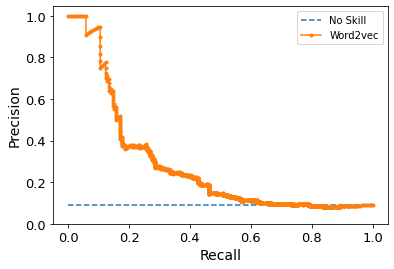

In [21]:
#precision-recall curve - compute precision-recall pairs for different probability thresholds
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, prevs_prob)

no_skill = y_test.count(1) / len(y_test)

#no-skill classifier
pyplot.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')

#word2vec classifier
pyplot.plot(recall, precision, marker = '.', label = 'Word2vec')

#labels
pyplot.xlabel('Recall', fontsize = 14)
pyplot.ylabel('Precision', fontsize = 14)

#ticks
pyplot.yticks(fontsize = 13)
pyplot.yticks(np.arange(0.0, 1.2, 0.2))
pyplot.xticks(fontsize = 13)

#legend
pyplot.legend()

#save
#plt.savefig(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Profiles/prcurve_transfers.png')

pyplot.show()